In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


#  Figures for Discussion -  Paper

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
#import sys
#sys.path.append("~/Documents/py_scripts/")
#import utils_SL as sl 
#import os
import cmocean as cm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

#%%
#import seaborn as sns
#from scipy import stats
from matplotlib.gridspec import GridSpec

#%%
#import cartopy.crs as ccrs
from cmocean import cm as cmo
#import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import matplotlib as mpl
#from matplotlib import ticker
from matplotlib.collections import LineCollection

#%%

from matplotlib.colors import ListedColormap

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict={1:"black", # WN
          2:"palegoldenrod", # PL
          3:"lightpink", # PLWN
          4:"orange", # AR1
          5:"teal", # Ar5
          6:"darkmagenta", # AR9
          7:"skyblue", # ARf
          8:"crimson" # GGM
          }

# We create a colormar from our list of colors
cmapnm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels =['WN','PL','PLWN','AR1','AR5','AR9','ARF','GGM']

#%%
import warnings; warnings.simplefilter('ignore')

#%% Define functions:

def rmv_season(tdec,height):
    # Remove seasonlity estimated by OLS
    # given a time vector (tdec) and a variant (height)
    # Returns the deseasonalinzed time series
    acc_idx = np.isfinite(height)
    design_matrix=np.ones([np.sum(acc_idx),6])
    design_matrix[:,1]=tdec[acc_idx]-np.nanmean(tdec) #linear trend
    design_matrix[:,2]=np.cos(2*np.pi*tdec[acc_idx]) # cos-annual
    design_matrix[:,3]=np.sin(2*np.pi*tdec[acc_idx]) # sin-annual
    design_matrix[:,4]=np.cos(2*np.pi*2*tdec[acc_idx]) #cos-semi-annual
    design_matrix[:,5]=np.sin(2*np.pi*2*tdec[acc_idx]) #sin semi-annual
    solution=np.linalg.lstsq(design_matrix,height[acc_idx],rcond=None)[0]
    
    annual=np.matmul(design_matrix[:,(2,3)],solution[2:4])
    semiannual=np.matmul(design_matrix[:,(4,5)],solution[4:6])

    season=np.array(annual+semiannual)
    
    deseason=np.array(height-season)
    
    return deseason


def lat2str(deg):
    # Source: https://github.com/matplotlib/basemap/blob/master/examples/customticks.py
    # Adapted so that 0 has no indication of direction.
    minn = 60 * (deg - np.floor(deg)) # transform to minutes
    deg = np.floor(deg) # degrees
    dirr = 'N'
    if deg < 0:
        if minn != 0.0:
            deg += 1.0
            minn -= 60.0
        dirr = 'S'
    elif deg == 0: dirr = ''
    return ("%d\N{DEGREE SIGN} %s") % (np.abs(deg),dirr)

def lon2str(deg):
    # Source: https://github.com/matplotlib/basemap/blob/master/examples/customticks.py
    # Adapted so that 0 has no indication of direction.
    minn = 60 * (deg - np.floor(deg))
    deg = np.floor(deg)
    dirr = ''#'E'
    if deg < 0:
        if minn != 0.0:
            deg += 1.0
            minn -= 60.0
        dirr = ''#'W'
    elif deg == 0: dirr =''
    return ("%d\N{DEGREE SIGN} %s") % (np.abs(deg),dirr)

def get_dry_msk(data):
    #given a value filed matrix, find the dry mask 
    #an array with 0 for where is land and 1 where is ocean.
    # Get our dry mask
    dry_msk=np.array(data)
    dry_msk[np.isnan(data)==False]=1 #ocean
    dry_msk[np.isnan(data)]=0 #land
    
    return dry_msk
#end of get_dry_msk
    
#*****************************************************************************
#*****************************************************************************
def get_ocean_area(lat,lon,dry_mask,plot=False,info=False):
    # Function that computes the ocean area given a latitude and longitude arrays.
    # Latitude and longitude should be in decimal degrees
    # It requires a dry mask: an array with 0 for where is land and 1 where is ocean.
    # Returns the ocean surface area in kmˆ2 (float number)
    # It also returns an area matrix (km^2), of size(len(lat),len(lon)). 
    # This is the 'weight' of the area in each grid cell. 
    
    R=6371 # Earth's radius in km
    
    #Check the grid resolution:
    deltalat=180/len(lat);
    deltalon=360/len(lon) 
    
    #Transform from degrees to km:

    deltay=(2*np.pi*R*deltalat)/360 #lat to km
    deltax=(2*np.pi*R*np.cos(np.radians(lat))*deltalon)/360 #lon to km
    
    area=np.array([deltax*deltay]*len(lon)).transpose()
    ocean_surf=np.sum(area*dry_mask)
    if info:
        print('The ocean surface is',ocean_surf, 'km^2')
        
        #https://hypertextbook.com/facts/1997/EricCheng.shtml
        ocean_lit=np.array([360000000,361060000,357000000,360008310,357000000])
        print('According to literature the surface should be',np.mean(ocean_lit),'±',round(np.std(ocean_lit)),'kmˆ2')
        
        dif=round((ocean_surf)/np.mean(ocean_lit),2)
        print('Your area is',dif,'of the literature value.')
    
    if plot:
        m=Basemap(projection='cyl',
              llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
              llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
              resolution='c')
    
    #Plot the field using the fast pcolormesh routine and set the colormap to jet.
        m.pcolormesh(lon,lat,dry_mask,shading='flat', 
              cmap='Paired')
        plt.colorbar(label='0=land,1=ocean',orientation='horizontal')
        plt.gca().set(title='Dry mask')
    # end of if loop

    
    return ocean_surf, area
#end of get_ocean_area

#%%
def rmse(pred, obs):

    differences = pred - obs    #the DIFFERENCEs between the predicted and the observed.

    differences_squared = differences ** 2  #the SQUAREs of ^

    mse = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mse) #ROOT of ^

    return rmse_val, mse

def R_sqrd(pred,obs):
    
    SSE = np.sum((obs-pred)**2) # Sum of Squareds of errors(residuals)
    
    SST = np.sum((obs-np.nanmean(obs))**2) # Total Sum of Squares
    
    r = 1 - (float(SSE))/SST
    
    return r

def get_filelist_sufix(path,  #'/Volumes/ccamargo/Data/'
                 sufix='', #'*grb'
                 sort=True
                 ):
    flist=[filename for filename in os.listdir(path) 
    if filename.endswith(sufix)]
    if sort:
        flist=sorted(flist) # Force it to be in the right order
    
    return flist




## RMSE Analysis

From 2005-2015:

In [3]:
#%%
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/time_series_global_2005-2015.nc')
ds


ens=np.array(ds.glbmu[18,:])
obs=np.array(ds.glbmu[0:18,:])

rmse(ens,obs[0,:])

out=np.zeros((18))
out2=np.zeros((18))
out3=np.zeros((18))
for i in range(18):
    out[i],out2[i]=rmse(ens,obs[i,:])
    out3[i]=R_sqrd(ens,obs[i,:])
    
df=pd.DataFrame(out,columns=['RMSE'])
df['MSE']=out2
df['R2']=out3
df['dataset']=ds.fname[0:18]
print(df.round(2))

#%%
ens=np.array(ds.glbmu[18,:])
obs=np.array(ds.glbmu[0:15])
rmse(ens,obs[0,:])

out=np.zeros((15))
out2=np.zeros((15))
out3=np.zeros((15))
for i in range(15):
    out[i],out2[i]=rmse(ens,obs[i,:])
    out3[i]=R_sqrd(ens,obs[i,:])
    
df=pd.DataFrame(out,columns=['RMSE'])
df['MSE']=out2
df['R2']=out3
df['dataset']=ds.fname[0:15]

    RMSE  MSE    R2  dataset
0   0.00  0.0  0.81    APDRC
1   0.00  0.0  0.84    SIORG
2   0.00  0.0  0.76  Armor3D
3   0.00  0.0  0.68      BOA
4   0.00  0.0  0.95   CGlors
5   0.00  0.0  0.93     CORA
6   0.00  0.0  0.90      C17
7   0.00  0.0  0.90      EN4
8   0.01  0.0  0.52     FOAM
9   0.00  0.0  0.76   GLORYS
10  0.00  0.0  0.93     ISAS
11  0.00  0.0  0.93    ISAS+
12  0.00  0.0  0.93     IK09
13  0.00  0.0  0.86     ORAS
14  0.00  0.0  0.83     SODA
15  0.00  0.0  0.91     ARGO
16  0.00  0.0  0.98      MiS
17  0.00  0.0  0.93      REA


In [4]:
cutoff=0.7
#%%
print('Considering the ENS(15) as the reference, the smallest RMSE dataset is '+
      str(np.array(ds.fname[np.where(out==np.min(out))] ) ) +
     'and with the lowest MSE is '+
     str(np.array(ds.fname[np.where(out2==np.min(out2))] ) ) +
     '. The dataset with the highest R-squared is: '+ 
     str(np.array(ds.fname[np.where(out3==np.max(out3))] ) ) +
     '. The following datasets have a R-squared <' + str(cutoff) +': '+
     str(np.array(ds.fname[np.where(out3<cutoff)] ) ))

ds.fname[np.where(out2==np.min(out2))]
ds.fname[np.where(out3<cutoff)]
ds.fname[(np.where(out3==np.max(out3)))]    

#%%
# Argo group
j=4 # number of individual datasets
k=132 # length of time series
ens=np.array(ds.glbmu[15,:])
obs=np.zeros((j,k))
ind=[0,1,3,10]
name=ds.fname[ind]
for ii,i in enumerate(ind): obs[ii,:]=np.array(ds.glbmu[i,:])
out=np.zeros((j));out2=np.zeros((j));out3=np.zeros((j))
for i in range(j):
    out[i],out2[i]=rmse(ens,obs[i,:])
    out3[i]=R_sqrd(ens,obs[i,:])
    
df=pd.DataFrame(out,columns=['RMSE'])
df['MSE']=out2
df['R2']=out3
df['dataset']=ds.fname[ind]
df
#%%

#%%
print('Considering the Argo-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is '+
      str(np.array(name[np.where(out==np.min(out))] ) ) +
     'and with the lowest MSE is '+
     str(np.array(name[np.where(out2==np.min(out2))] ) ) +
     '. The dataset with the highest R-squared is: '+ 
     str(np.array(name[np.where(out3==np.max(out3))] ) ) +
     '. The following datasets have a R-squared <' + str(cutoff) +': '+
     str(np.array(name[np.where(out3<cutoff)] ) ))


#%%
# MiS group
j=6 # number of individual datasets
k=132 # length of time series
ens=np.array(ds.glbmu[15,:])
obs=np.zeros((j,k))
ind=[2,5,6,7,11,12]
name=ds.fname[ind]
for ii,i in enumerate(ind): obs[ii,:]=np.array(ds.glbmu[i,:])
out=np.zeros((j));out2=np.zeros((j));out3=np.zeros((j))
for i in range(j):
    out[i],out2[i]=rmse(ens,obs[i,:])
    out3[i]=R_sqrd(ens,obs[i,:])
    
df=pd.DataFrame(out,columns=['RMSE'])
df['MSE']=out2
df['R2']=out3
df['dataset']=ds.fname[ind]
df
#%%
print('Considering the MiS-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is '+
      str(np.array(name[np.where(out==np.min(out))] ) ) +
     'and with the lowest MSE is '+
     str(np.array(name[np.where(out2==np.min(out2))] ) ) +
     '. The dataset with the highest R-squared is: '+ 
     str(np.array(name[np.where(out3==np.max(out3))] ) ) +
     '. The following datasets have a R-squared <' + str(cutoff) +': '+
     str(np.array(name[np.where(out3<cutoff)] ) ))

 
#%%
# REA group
j=5 # number of individual datasets
k=132 # length of time series
ens=np.array(ds.glbmu[15,:])
obs=np.zeros((j,k))
ind=[4,8,9,13,14]
name=ds.fname[ind]
for ii,i in enumerate(ind): obs[ii,:]=np.array(ds.glbmu[i,:])
out=np.zeros((j));out2=np.zeros((j));out3=np.zeros((j))
for i in range(j):
    out[i],out2[i]=rmse(ens,obs[i,:])
    out3[i]=R_sqrd(ens,obs[i,:])
    
df=pd.DataFrame(out,columns=['RMSE'])
df['MSE']=out2
df['R2']=out3
df['dataset']=ds.fname[ind]
df
#%%
print('Considering the REA-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is '+
      str(np.array(name[np.where(out==np.min(out))] ) ) +
     'and with the lowest MSE is '+
     str(np.array(name[np.where(out2==np.min(out2))] ) ) +
     '. The dataset with the highest R-squared is: '+ 
     str(np.array(name[np.where(out3==np.max(out3))] ) ) +
     '. The following datasets have a R-squared <' + str(cutoff) +': '+
     str(np.array(name[np.where(out3<cutoff)] ) ))





Considering the ENS(15) as the reference, the smallest RMSE dataset is ['ISAS+']and with the lowest MSE is ['ISAS+']. The dataset with the highest R-squared is: ['CGlors']. The following datasets have a R-squared <0.7: ['BOA' 'FOAM']
Considering the Argo-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is ['ISAS']and with the lowest MSE is ['ISAS']. The dataset with the highest R-squared is: ['ISAS']. The following datasets have a R-squared <0.7: []
Considering the MiS-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is ['ISAS+']and with the lowest MSE is ['ISAS+']. The dataset with the highest R-squared is: ['ISAS+']. The following datasets have a R-squared <0.7: []
Considering the REA-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is ['CGlors']and with the lowest MSE is ['CGlors']. The dataset with the highest R-squared is: ['CGlors']. The follow

From 1993-2017:

In [5]:

#%% 1993-2017
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/time_series_global_1993-2017.nc')
ds


ens=np.array(ds.glbmu[12,:])
obs=np.array(ds.glbmu[0:12,:])

rmse(ens,obs[0,:])

out=np.zeros((12))
out2=np.zeros((12))
out3=np.zeros((12))
for i in range(12):
    out[i],out2[i]=rmse(ens,obs[i,:])
    out3[i]=R_sqrd(ens,obs[i,:])
    
df=pd.DataFrame(out,columns=['RMSE'])
df['MSE']=out2
df['R2']=out3
df['dataset']=ds.fname[0:12]
print(df.round(2))


ens=np.array(ds.glbmu[12,:])
obs=np.array(ds.glbmu[0:10,:])


out=np.zeros((10))
out2=np.zeros((10))
out3=np.zeros((10))
for i in range(10):
    out[i],out2[i]=rmse(ens,obs[i,:])
    out3[i]=R_sqrd(ens,obs[i,:])
    
df=pd.DataFrame(out,columns=['RMSE'])
df['MSE']=out2
df['R2']=out3
df['dataset']=ds.fname[0:10]

#%%


    RMSE  MSE    R2  dataset
0   0.01  0.0  0.84  Armor3D
1   0.00  0.0  0.96   CGlors
2   0.00  0.0  0.75     CORA
3   0.00  0.0  0.85      C17
4   0.00  0.0  0.93      EN4
5   0.01  0.0  0.37     FOAM
6   0.01  0.0  0.85   GLORYS
7   0.00  0.0  0.67     IK09
8   0.01  0.0  0.81     ORAS
9   0.00  0.0  0.90     SODA
10  0.00  0.0  0.89      MiS
11  0.00  0.0  0.94      REA


In [6]:
print('Considering the ENS(10) as the reference, the smallest RMSE dataset is '+
      str(np.array(ds.fname[np.where(out==np.min(out))] ) ) +
     'and with the lowest MSE is '+
     str(np.array(ds.fname[np.where(out2==np.min(out2))] ) ) +
     '. The dataset with the highest R-squared is: '+ 
     str(np.array(ds.fname[np.where(out3==np.max(out3))] ) ) +
     '. The following datasets have a R-squared <' + str(cutoff) +': '+
     str(np.array(ds.fname[np.where(out3<cutoff)] ) ))   

#%%
ds.fname
#%%
# MiS group
j=5 # number of individual datasets
k=300 # length of time series
ens=np.array(ds.glbmu[10,:])
obs=np.zeros((j,k))
ind=[0,2,3,4,7]
name=ds.fname[ind]
for ii,i in enumerate(ind): obs[ii,:]=np.array(ds.glbmu[i,:])
out=np.zeros((j));out2=np.zeros((j));out3=np.zeros((j))
for i in range(j):
    out[i],out2[i]=rmse(ens,obs[i,:])
    out3[i]=R_sqrd(ens,obs[i,:])
    
df=pd.DataFrame(out,columns=['RMSE'])
df['MSE']=out2
df['R2']=out3
df['dataset']=ds.fname[ind]
df
#%%
print('Considering the MiS-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is '+
      str(np.array(name[np.where(out==np.min(out))] ) ) +
     'and with the lowest MSE is '+
     str(np.array(name[np.where(out2==np.min(out2))] ) ) +
     '. The dataset with the highest R-squared is: '+ 
     str(np.array(name[np.where(out3==np.max(out3))] ) ) +
     '. The following datasets have a R-squared <' + str(cutoff) +': '+
     str(np.array(name[np.where(out3<cutoff)] ) ))


#%%
# REA group
j=5 # number of individual datasets
k=300 # length of time series
ens=np.array(ds.glbmu[11,:])
obs=np.zeros((j,k))
ind=[1,5,6,8,9]
name=ds.fname[ind]
for ii,i in enumerate(ind): obs[ii,:]=np.array(ds.glbmu[i,:])
out=np.zeros((j));out2=np.zeros((j));out3=np.zeros((j))
for i in range(j):
    out[i],out2[i]=rmse(ens,obs[i,:])
    out3[i]=R_sqrd(ens,obs[i,:])
    
df=pd.DataFrame(out,columns=['RMSE'])
df['MSE']=out2
df['R2']=out3
df['dataset']=ds.fname[ind]
df
#%%
print('Considering the REA-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is '+
      str(np.array(name[np.where(out==np.min(out))] ) ) +
     'and with the lowest MSE is '+
     str(np.array(name[np.where(out2==np.min(out2))] ) ) +
     '. The dataset with the highest R-squared is: '+ 
     str(np.array(name[np.where(out3==np.max(out3))] ) ) +
     '. The following datasets have a R-squared <' + str(cutoff) +': '+
     str(np.array(name[np.where(out3<cutoff)] ) ))

Considering the ENS(10) as the reference, the smallest RMSE dataset is ['CGlors']and with the lowest MSE is ['CGlors']. The dataset with the highest R-squared is: ['CGlors']. The following datasets have a R-squared <0.7: ['FOAM' 'IK09']
Considering the MiS-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is ['CORA']and with the lowest MSE is ['CORA']. The dataset with the highest R-squared is: ['CORA']. The following datasets have a R-squared <0.7: []
Considering the REA-group mean as the reference for the individual dataets of the group, the smallest RMSE dataset is ['CGlors']and with the lowest MSE is ['CGlors']. The dataset with the highest R-squared is: ['CGlors']. The following datasets have a R-squared <0.7: ['FOAM']


# Plots

In [7]:
ds2=xr.open_dataset('~/Desktop/paper1/steric/data/pub/landmask_etopo1_360x132.nc')
ds2
lat=np.array(ds2.lat)
lon=np.array(ds2.lon)
mask=np.array(ds2.mask)

ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_2005-2015.nc')
ds

nm=np.array(ds.nm)
name=np.array(ds.fname)
i=11
name[i]

'ISAS+'

In [8]:
name=name[i]
trend=np.array(ds.trend[i,:,:,:]) # AR1
trend=mask*trend
unc=np.array(ds.unc[i,:,:,:])
unc=unc*mask
aic=np.array(ds.aic[i,:,:,:])
bic=np.array(ds.bic[i,:,:,:])
aicbic=np.nanmean([aic,bic],axis=0)

#%%
aic=aic*mask
bic=bic*mask
aicbic=aicbic*mask
#%%
rkb=np.zeros((len(lat),len(lon)))
rkb[:,:]='nan'
rka=np.zeros((len(lat),len(lon)))
rka[:,:]='nan'
rk=np.zeros((len(lat),len(lon)))
rk[:,:]='nan'


ilat=ilon=j=5
for ilat,l in enumerate(lat):
    for ilon,l in enumerate(lon):
        
        if ~np.isnan(mask[ilat,ilon]):
            targeta=aic[:,ilat,ilon] # All datasets and noise-models for this lat and lon
            targetb=bic[:,ilat,ilon]       
            target=aicbic[:,ilat,ilon]
            
            bic2=np.zeros((len(name),len(nm)))
            aic2=np.zeros((len(name),len(nm)))
            aicbic2=np.zeros((len(name),len(nm)))
    
            for iname in np.arange(0,len(name)):
                
##                AIC
                tg=targeta[:] # all noise models for this dataset
                logaic=np.zeros((tg.shape))
                for inm in np.arange(0,len(nm)):
                    logaic[inm]=np.exp((np.nanmin(tg)-tg[inm])/2)
                
                logaic 
                indaic=np.where(logaic>0.5)
                indaic=np.array(indaic)
                for inm in np.arange(0,len(nm)):
                    for ind in indaic:
                        for ind2 in ind:
                            if inm==ind2:        
                                aic2[iname,inm]=1
#                
                
                #BIC
                tg=targetb[:]
                tg
                logbic=np.zeros((tg.shape))
                for inm in np.arange(0,len(nm)):
                    logbic[inm]=np.exp((np.nanmin(tg)-tg[inm])/2)
                
                logbic 
                indbic=np.where(logbic>0.5)
                indbic=np.array(indbic)
                indbic
                for inm in np.arange(0,len(nm)):
                    for ind in indbic:
                        for ind2 in ind:
                            if inm==ind2:        
                                bic2[iname,inm]=1
                #AIC|BIC
                tg=target[:]
                tg
                logab=np.zeros((tg.shape))
                for inm in np.arange(0,len(nm)):
                    logab[inm]=np.exp((np.nanmin(tg)-tg[inm])/2)
                
                logab 
                indab=np.where(logab>0.5)
                indab=np.array(indab)
                indab
                for inm in np.arange(0,len(nm)):
                    for ind in indab:
                        for ind2 in ind:
                            if inm==ind2:        
                                aicbic2[iname,inm]=1
                                
            
            indaic=np.sum(aic2,axis=0)                   
            tmp=np.array(np.where(indaic==np.nanmax(indaic)))
            rka[ilat,ilon]=tmp[0,0]
            
            indbic=np.sum(bic2,axis=0)
            tmp=np.array(np.where(indbic==np.nanmax(indbic)))
            rkb[ilat,ilon]=tmp[0,0]

            indab=np.sum(aicbic2,axis=0)
            tmp=np.array(np.where(indab==np.nanmax(indab)))
            rk[ilat,ilon]=tmp[0,0]

            

In [9]:
rka05=np.array(rka)
rkb05=np.array(rkb)
rk05=np.array(rk)
trend05=np.array(trend)
unc05=np.array(unc)

In [10]:
#%%
#1993-2017

ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_1993-2017.nc')
ds

nm=np.array(ds.nm)
name=np.array(ds.fname)
i=2 # ensemble mean
name[i]

'CORA'

In [11]:
name=name[i]
trend=np.array(ds.trend[i,:,:,:]) # AR1
trend=mask*trend
unc=np.array(ds.unc[i,:,:,:])
unc=unc*mask
aic=np.array(ds.aic[i,:,:,:])
bic=np.array(ds.bic[i,:,:,:])
aicbic=np.nanmean([aic,bic],axis=0)

#%%
aic=aic*mask
bic=bic*mask
aicbic=aicbic*mask
#%%
rkb=np.zeros((len(lat),len(lon)))
rkb[:,:]='nan'
rka=np.zeros((len(lat),len(lon)))
rka[:,:]='nan'
rk=np.zeros((len(lat),len(lon)))
rk[:,:]='nan'


ilat=ilon=j=5
for ilat,l in enumerate(lat):
    for ilon,l in enumerate(lon):
        
        if ~np.isnan(mask[ilat,ilon]):
            targeta=aic[:,ilat,ilon] # All datasets and noise-models for this lat and lon
            targetb=bic[:,ilat,ilon]       
            target=aicbic[:,ilat,ilon]
            
            bic2=np.zeros((len(name),len(nm)))
            aic2=np.zeros((len(name),len(nm)))
            aicbic2=np.zeros((len(name),len(nm)))
    
            for iname in np.arange(0,len(name)):
                
##                AIC
                tg=targeta[:] # all noise models for this dataset
                logaic=np.zeros((tg.shape))
                for inm in np.arange(0,len(nm)):
                    logaic[inm]=np.exp((np.nanmin(tg)-tg[inm])/2)
                
                logaic 
                indaic=np.where(logaic>0.5)
                indaic=np.array(indaic)
                for inm in np.arange(0,len(nm)):
                    for ind in indaic:
                        for ind2 in ind:
                            if inm==ind2:        
                                aic2[iname,inm]=1
#                
                
                #BIC
                tg=targetb[:]
                tg
                logbic=np.zeros((tg.shape))
                for inm in np.arange(0,len(nm)):
                    logbic[inm]=np.exp((np.nanmin(tg)-tg[inm])/2)
                
                logbic 
                indbic=np.where(logbic>0.5)
                indbic=np.array(indbic)
                indbic
                for inm in np.arange(0,len(nm)):
                    for ind in indbic:
                        for ind2 in ind:
                            if inm==ind2:        
                                bic2[iname,inm]=1
                #AIC|BIC
                tg=target[:]
                tg
                logab=np.zeros((tg.shape))
                for inm in np.arange(0,len(nm)):
                    logab[inm]=np.exp((np.nanmin(tg)-tg[inm])/2)
                
                logab 
                indab=np.where(logab>0.5)
                indab=np.array(indab)
                indab
                for inm in np.arange(0,len(nm)):
                    for ind in indab:
                        for ind2 in ind:
                            if inm==ind2:        
                                aicbic2[iname,inm]=1
                                
            
            indaic=np.sum(aic2,axis=0)                   
            tmp=np.array(np.where(indaic==np.nanmax(indaic)))
            rka[ilat,ilon]=tmp[0,0]
            
            indbic=np.sum(bic2,axis=0)
            tmp=np.array(np.where(indbic==np.nanmax(indbic)))
            rkb[ilat,ilon]=tmp[0,0]

            indab=np.sum(aicbic2,axis=0)
            tmp=np.array(np.where(indab==np.nanmax(indab)))
            rk[ilat,ilon]=tmp[0,0]




In [12]:
#%%
rka93=np.array(rka)
rkb93=np.array(rkb)
rk93=np.array(rk)
trend93=np.array(trend)
unc93=np.array(unc)

In [13]:
# Compute % of grid cells and % ocean area for each noise model, according to each selection criterea and time period

data=rka05

perc=np.zeros((len(nm)))
# count nans:
tmp=list(np.hstack(data))
j=np.array(np.where(np.isnan(tmp)))


for i in range(len(nm)):
   # print(i)
    #print(NM[i])
    tmp=list(np.hstack(data))
    perc[i]=(tmp.count(i)/(len(tmp)-len(j[0,:])))*100
    #print(perc_bic[i])

rel_area=np.zeros((len(nm)))
dry_msk=get_dry_msk(data)
total_area,area=get_ocean_area(lat,lon,dry_msk)
for i in range(len(nm)):
    tmp=np.copy(data)
    tmp[np.where(tmp!=i)]='nan'
    tmp[np.where(np.isnan(tmp)==False)]=1
    tmp[np.where(np.isnan(tmp))]=0
    surf,area=get_ocean_area(lat,lon,tmp)
    rel_area[i]=(surf/total_area)*100

df=pd.DataFrame(rel_area,columns=['aic_area05'])
df['aic_grid05']=perc

#%%
data=rkb05
perc=np.zeros((len(nm)))
# count nans:
tmp=list(np.hstack(data))
j=np.array(np.where(np.isnan(tmp)))


for i in range(len(nm)):
   # print(i)
    #print(NM[i])
    tmp=list(np.hstack(data))
    perc[i]=(tmp.count(i)/(len(tmp)-len(j[0,:])))*100
    #print(perc_bic[i])

rel_area=np.zeros((len(nm)))
dry_msk=get_dry_msk(data)
total_area,area=get_ocean_area(lat,lon,dry_msk)
for i in range(len(nm)):
    tmp=np.copy(data)
    tmp[np.where(tmp!=i)]='nan'
    tmp[np.where(np.isnan(tmp)==False)]=1
    tmp[np.where(np.isnan(tmp))]=0
    surf,area=get_ocean_area(lat,lon,tmp)
    rel_area[i]=(surf/total_area)*100

df['bic_area05']=rel_area
df['bic_grid05']=perc

#%%
data=rk05
perc=np.zeros((len(nm)))
# count nans:
tmp=list(np.hstack(data))
j=np.array(np.where(np.isnan(tmp)))


for i in range(len(nm)):
   # print(i)
    #print(NM[i])
    tmp=list(np.hstack(data))
    perc[i]=(tmp.count(i)/(len(tmp)-len(j[0,:])))*100
    #print(perc_bic[i])

rel_area=np.zeros((len(nm)))
dry_msk=get_dry_msk(data)
total_area,area=get_ocean_area(lat,lon,dry_msk)
for i in range(len(nm)):
    tmp=np.copy(data)
    tmp[np.where(tmp!=i)]='nan'
    tmp[np.where(np.isnan(tmp)==False)]=1
    tmp[np.where(np.isnan(tmp))]=0
    surf,area=get_ocean_area(lat,lon,tmp)
    rel_area[i]=(surf/total_area)*100

df['aicbic_area05']=rel_area
df['aicbic_grid05']=perc

#%%
data=rka93

perc=np.zeros((len(nm)))
# count nans:
tmp=list(np.hstack(data))
j=np.array(np.where(np.isnan(tmp)))


for i in range(len(nm)):
   # print(i)
    #print(NM[i])
    tmp=list(np.hstack(data))
    perc[i]=(tmp.count(i)/(len(tmp)-len(j[0,:])))*100
    #print(perc_bic[i])

rel_area=np.zeros((len(nm)))
dry_msk=get_dry_msk(data)
total_area,area=get_ocean_area(lat,lon,dry_msk)
for i in range(len(nm)):
    tmp=np.copy(data)
    tmp[np.where(tmp!=i)]='nan'
    tmp[np.where(np.isnan(tmp)==False)]=1
    tmp[np.where(np.isnan(tmp))]=0
    surf,area=get_ocean_area(lat,lon,tmp)
    rel_area[i]=(surf/total_area)*100

df['aic_area93']=rel_area
df['aic_grid93']=perc

#%%
data=rkb93
perc=np.zeros((len(nm)))
# count nans:
tmp=list(np.hstack(data))
j=np.array(np.where(np.isnan(tmp)))


for i in range(len(nm)):
   # print(i)
    #print(NM[i])
    tmp=list(np.hstack(data))
    perc[i]=(tmp.count(i)/(len(tmp)-len(j[0,:])))*100
    #print(perc_bic[i])

rel_area=np.zeros((len(nm)))
dry_msk=get_dry_msk(data)
total_area,area=get_ocean_area(lat,lon,dry_msk)
for i in range(len(nm)):
    tmp=np.copy(data)
    tmp[np.where(tmp!=i)]='nan'
    tmp[np.where(np.isnan(tmp)==False)]=1
    tmp[np.where(np.isnan(tmp))]=0
    surf,area=get_ocean_area(lat,lon,tmp)
    rel_area[i]=(surf/total_area)*100

df['bic_area93']=rel_area
df['bic_grid93']=perc

#%%
data=rk93
perc=np.zeros((len(nm)))
# count nans:
tmp=list(np.hstack(data))
j=np.array(np.where(np.isnan(tmp)))


for i in range(len(nm)):
   # print(i)
    #print(NM[i])
    tmp=list(np.hstack(data))
    perc[i]=(tmp.count(i)/(len(tmp)-len(j[0,:])))*100
    #print(perc_bic[i])

rel_area=np.zeros((len(nm)))
dry_msk=get_dry_msk(data)
total_area,area=get_ocean_area(lat,lon,dry_msk)
for i in range(len(nm)):
    tmp=np.copy(data)
    tmp[np.where(tmp!=i)]='nan'
    tmp[np.where(np.isnan(tmp)==False)]=1
    tmp[np.where(np.isnan(tmp))]=0
    surf,area=get_ocean_area(lat,lon,tmp)
    rel_area[i]=(surf/total_area)*100

df['aicbic_area93']=rel_area
df['aicbic_grid93']=perc

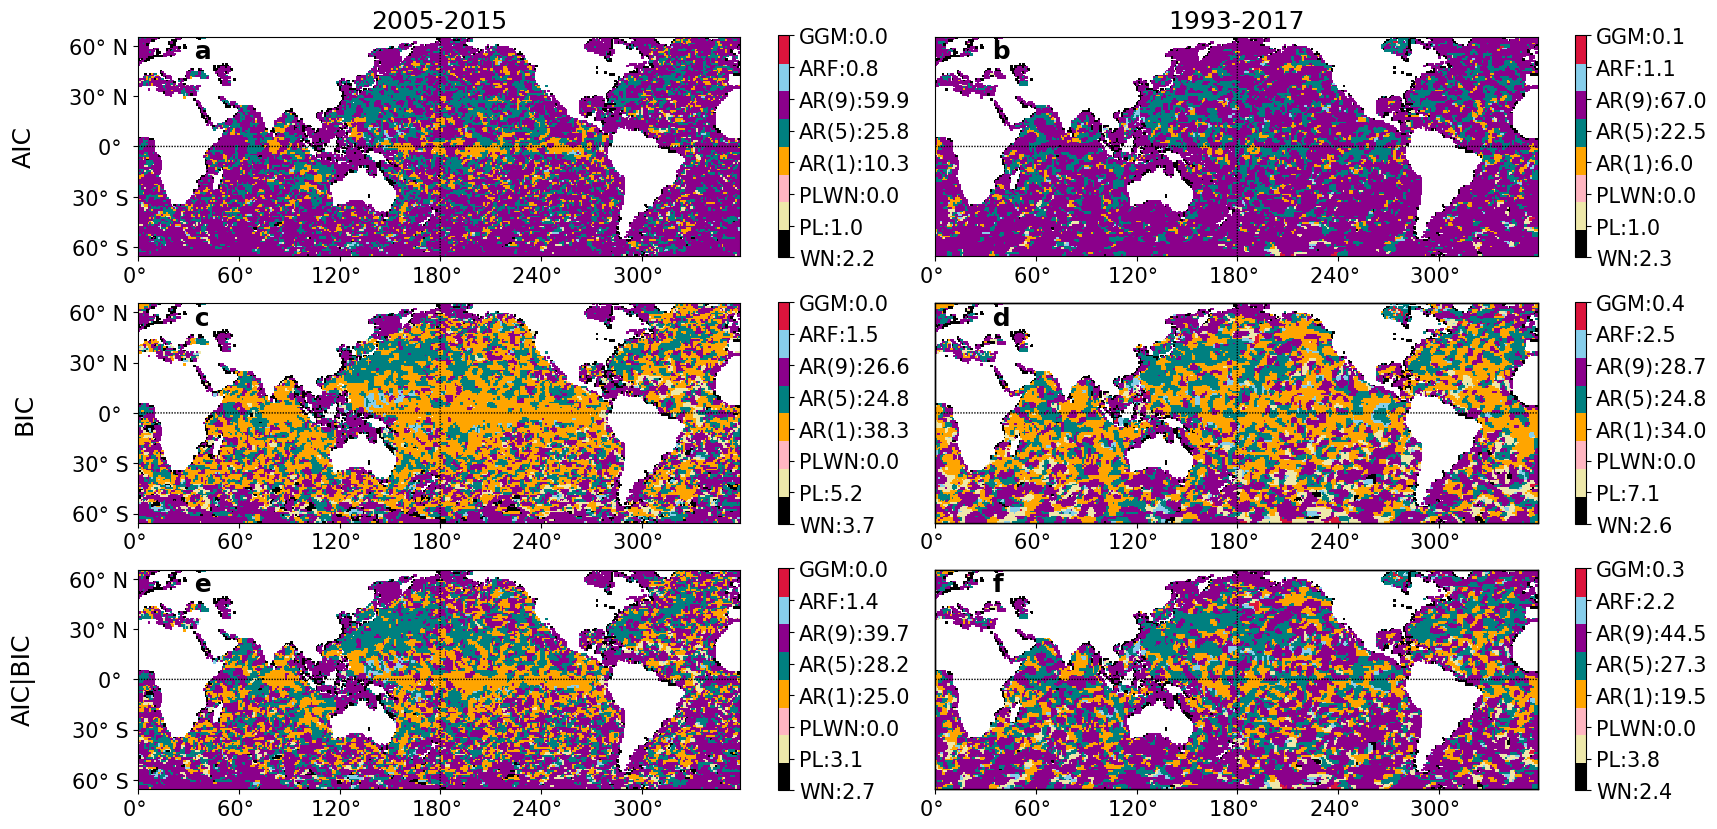

In [14]:
#%% PLOT
fig=plt.figure(figsize=(20,10),dpi=100)
gs = GridSpec(3, 6, figure=fig)

cmax=7
cmin=0
cmap=plt.cm.get_cmap('Set3', cmax+1)

# AIC
ax1 = plt.subplot(gs.new_subplotspec((0, 0),colspan=3))
data=rka05

perc=np.array(df.aic_area05)

lb=list(nm)
for i in range(len(nm)):
    lb[i]=str(nm[i]+":"+str(np.round(perc[i],1)) )



m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmapnm)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax1.set_xticks(deg)
ax1.set_xticklabels(lblon,fontsize=15)

deg=np.arange(-60,61,30)
lblat=[None]*len(deg)
for i,d in enumerate(deg): lblat[i]=lat2str(d)
ax1.set_yticks(deg)
ax1.set_yticklabels(lblat,fontsize=15)

cbar=plt.colorbar(cax,ticks=range(len(nm)), #shrink=0.7,
                  #label='Preferred Noise Model',fontsize=15,
                  orientation='vertical')
cbar.ax.set_yticklabels(lb,fontsize=15) # horizontally oriented colorbar
plt.title('2005-2015',fontsize=18)

ax1.text(0.08,0.90,' a ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)
plt.ylabel('AIC\n',fontsize=18)


#%
#########################
# BIC
ax1 = plt.subplot(gs.new_subplotspec((1, 0),colspan=3))

data=rkb05
perc=np.array(df.bic_area05)
lb=list(nm)
for i in range(len(nm)):
    lb[i]=str(nm[i]+":"+str(np.round(perc[i],1)) )
    

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmapnm)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax1.set_xticks(deg)
ax1.set_xticklabels(lblon,fontsize=15)

deg=np.arange(-60,61,30)
lblat=[None]*len(deg)
for i,d in enumerate(deg): lblat[i]=lat2str(d)
ax1.set_yticks(deg)
ax1.set_yticklabels(lblat,fontsize=15)

cbar=plt.colorbar(cax,ticks=range(len(nm)), #shrink=0.7,
                  #label='Preferred Noise Model',fontsize=15,
                  orientation='vertical')
cbar.ax.set_yticklabels(lb,fontsize=15) # horizontally oriented colorbar
plt.ylabel('BIC\n',fontsize=18)
ax1.text(0.08,0.90,' c ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)
#plt.ylabel('Latitude\n',fontsize=15)


####################
# AIC|BIC
ax1 = plt.subplot(gs.new_subplotspec((2, 0),colspan=3))

data=rk05
perc=np.array(df.aicbic_area05)
lb=list(nm)
for i in range(len(nm)):
    lb[i]=str(nm[i]+":"+str(np.round(perc[i],1)) )
    


m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmapnm)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax1.set_xticks(deg)
ax1.set_xticklabels(lblon,fontsize=15)

deg=np.arange(-60,61,30)
lblat=[None]*len(deg)
for i,d in enumerate(deg): lblat[i]=lat2str(d)
ax1.set_yticks(deg)
ax1.set_yticklabels(lblat,fontsize=15)

cbar=plt.colorbar(cax,ticks=range(len(nm)), #shrink=0.7,
                  #label='Preferred Noise Model',fontsize=15,
                  orientation='vertical')
cbar.ax.set_yticklabels(lb,fontsize=15) # horizontally oriented colorbar
plt.ylabel('AIC|BIC\n',fontsize=18)
ax1.text(0.08,0.90,' e ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)
#plt.ylabel('Latitude\n',fontsize=15)
#plt.xlabel('\nLongitude',fontsize=15)

##################
#################
# AIC
ax1 = plt.subplot(gs.new_subplotspec((0, 3),colspan=3))
data=rka93

perc=np.array(df.aic_area93)
lb=list(nm)
for i in range(len(nm)):
    lb[i]=str(nm[i]+":"+str(np.round(perc[i],1)) )


m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmapnm)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax1.set_xticks(deg)
ax1.set_xticklabels(lblon,fontsize=15)

#deg=np.arange(-60,61,30)
#lblat=[None]*len(deg)
#for i,d in enumerate(deg): lblat[i]=lat2str(d)
#ax1.set_yticks(deg)
#ax1.set_yticklabels(lblat,fontsize=15)



cbar=plt.colorbar(cax,ticks=range(len(nm)), #shrink=0.7,
                  #label='Preferred Noise Model',fontsize=15,
                  orientation='vertical')

cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticklabels(lb,fontsize=15) # horizontally oriented colorbarcbar.ax.set_xticklabels(lb,fontsize=10,rotation=45) # horizontally oriented colorbar
plt.title('1993-2017',fontsize=18)

ax1.text(0.08,0.90,' b ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

#%
#########################
# BIC
ax1 = plt.subplot(gs.new_subplotspec((1, 3),colspan=3))

data=rkb93
perc=np.array(df.bic_area93)
lb=list(nm)
for i in range(len(nm)):
    lb[i]=str(nm[i]+":"+str(np.round(perc[i],1)) )


m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmapnm)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax1.set_xticks(deg)
ax1.set_xticklabels(lblon,fontsize=15)

#deg=np.arange(-60,61,30)
#lblat=[None]*len(deg)
#for i,d in enumerate(deg): lblat[i]=lat2str(d)
#ax1.set_yticks(deg)
#ax1.set_yticklabels(lblat,fontsize=15)



m.drawmapboundary()


cbar=plt.colorbar(cax,ticks=range(len(nm)), 
                  #shrink=0.7,
                  #label='Preferred Noise Model',fontsize=15,
                  orientation='vertical')
cbar.ax.set_yticklabels(lb,fontsize=15) # horizontally oriented colorbar
#plt.title('BIC',fontsize=18)
ax1.text(0.08,0.90,' d ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

####################
# AIC|BIC
ax1 = plt.subplot(gs.new_subplotspec((2, 3),colspan=3))

data=rk93
perc=np.array(df.aicbic_area93)
lb=list(nm)
for i in range(len(nm)):
    lb[i]=str(nm[i]+":"+str(np.round(perc[i],1)) )
    


m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmapnm)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax1.set_xticks(deg)
ax1.set_xticklabels(lblon,fontsize=15)

#deg=np.arange(-60,61,30)
#lblat=[None]*len(deg)
#for i,d in enumerate(deg): lblat[i]=lat2str(d)
#ax1.set_yticks(deg)
#ax1.set_yticklabels(lblat,fontsize=15)


m.drawmapboundary()

##plt.xlabel('\nLongitude',fontsize=15)
cbar=plt.colorbar(cax,ticks=range(len(nm)), 
                  ##shrink=0.95,
                  #label='Preferred Noise Model',fontsize=15,
                  orientation='vertical')
cbar.ax.set_yticklabels(lb,fontsize=15) # horizontally oriented colorbar
#plt.title('AIC|BIC',fontsize=18)
ax1.text(0.08,0.90,' f ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)



plt.show()


fig.savefig('/Users/ccamargo/Desktop/paper1/figuresv4/pdf/SI_7_NM_scores_CGlors.pdf',
            format='pdf',dpi=200,bbox_inches='tight')

fig.savefig('/Users/ccamargo/Desktop/paper1/figuresv4/png/SI_7_NM_scores_CGlors.png',
            format='png',dpi=200,bbox_inches='tight')


Figure. Preferred noise model for ISAS+ (left) and CGlors (right)


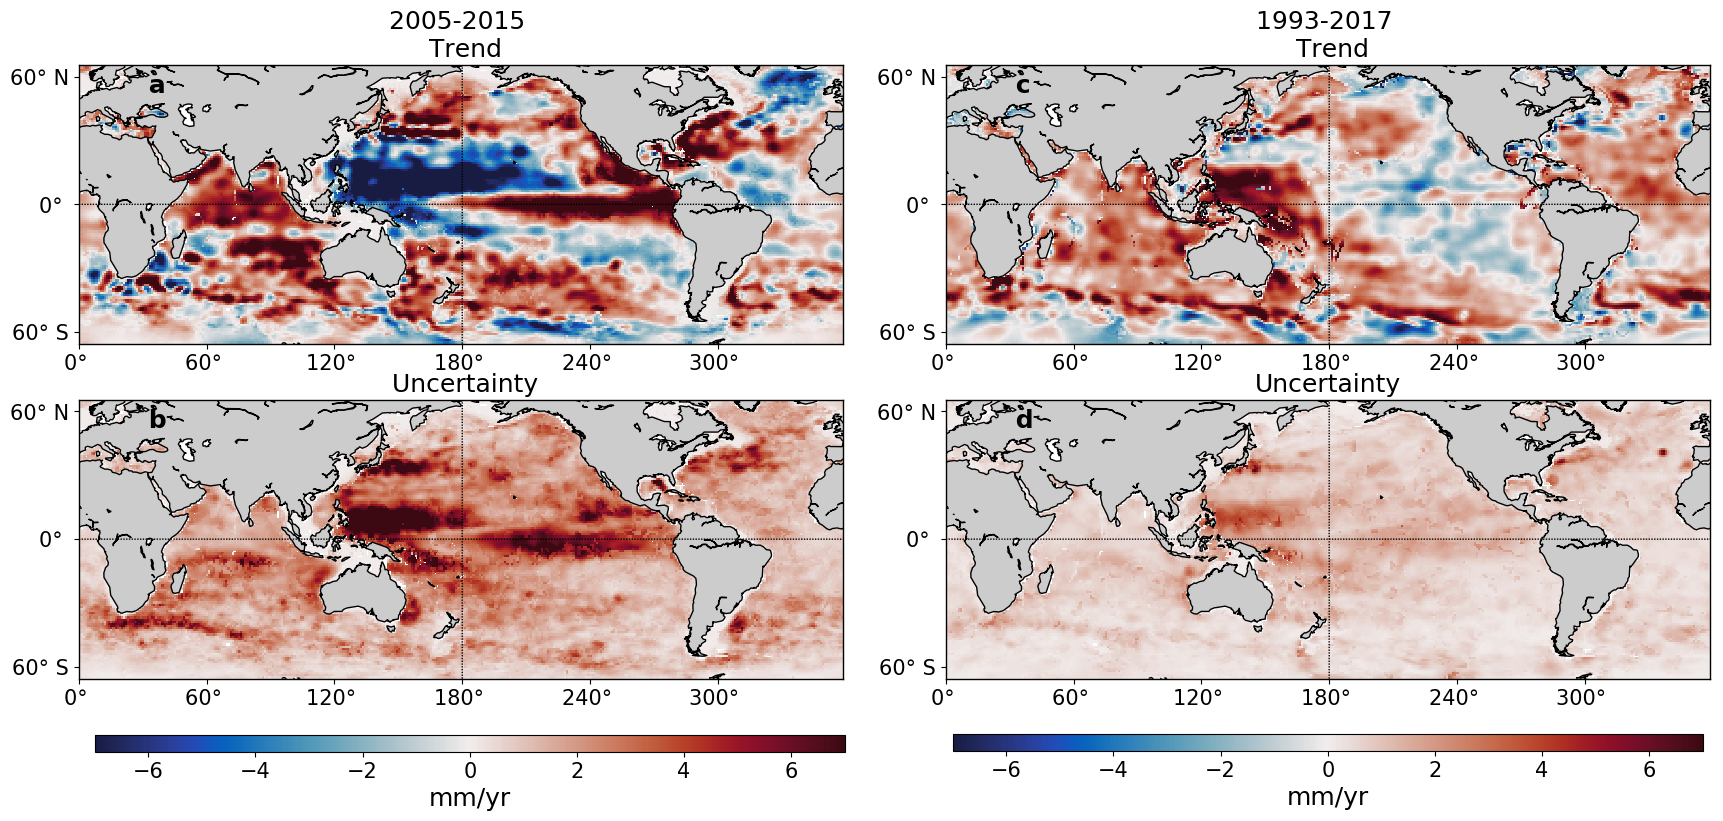

In [15]:

#Figure 8 - needs data from Figure 7!

#2005-2015
trend_aic05=np.zeros((len(lat),len(lon)))
trend_aic05.fill('nan')
trend_bic05=np.zeros((len(lat),len(lon)))
trend_bic05.fill('nan')
trend_aicbic05=np.zeros((len(lat),len(lon)))
trend_aicbic05.fill('nan')

unc_aic05=np.zeros((len(lat),len(lon)))
unc_aic05.fill('nan')
unc_bic05=np.zeros((len(lat),len(lon)))
unc_bic05.fill('nan')
unc_aicbic05=np.zeros((len(lat),len(lon)))
unc_aicbic05.fill('nan')
for ilat,l in enumerate(lat):
    for ilon,l in enumerate(lon):
            ind=np.array(rka05[ilat,ilon])
            if np.isnan(ind):
                trend_aic05[ilat,ilon]='nan'
                unc_aic05[ilat,ilon]='nan'
            else:
                trend_aic05[ilat,ilon]=trend05[int(ind),ilat,ilon]
                unc_aic05[ilat,ilon]=unc05[int(ind),ilat,ilon]
            
            ind=np.array(rkb05[ilat,ilon])
            if np.isnan(ind):
                trend_bic05[ilat,ilon]='nan'
                unc_bic05[ilat,ilon]='nan'
            else:
                trend_bic05[ilat,ilon]=trend05[int(ind),ilat,ilon]
                unc_bic05[ilat,ilon]=unc05[int(ind),ilat,ilon]
            
            ind=np.array(rk05[ilat,ilon])
            if np.isnan(ind):
                trend_aicbic05[ilat,ilon]='nan'
                unc_aicbic05[ilat,ilon]='nan'
            else:
                trend_aicbic05[ilat,ilon]=trend05[int(ind),ilat,ilon]
                unc_aicbic05[ilat,ilon]=unc05[int(ind),ilat,ilon]


#1993-2017
trend_aic93=np.zeros((len(lat),len(lon)))
trend_aic93.fill('nan')
trend_bic93=np.zeros((len(lat),len(lon)))
trend_bic93.fill('nan')
trend_aicbic93=np.zeros((len(lat),len(lon)))
trend_aicbic93.fill('nan')

unc_aic93=np.zeros((len(lat),len(lon)))
unc_aic93.fill('nan')
unc_bic93=np.zeros((len(lat),len(lon)))
unc_bic93.fill('nan')
unc_aicbic93=np.zeros((len(lat),len(lon)))
unc_aicbic93.fill('nan')
for ilat,l in enumerate(lat):
    for ilon,l in enumerate(lon):
            ind=np.array(rka93[ilat,ilon])
            if np.isnan(ind):
                trend_aic93[ilat,ilon]='nan'
                unc_aic93[ilat,ilon]='nan'
            else:
                trend_aic93[ilat,ilon]=trend93[int(ind),ilat,ilon]
                unc_aic93[ilat,ilon]=unc93[int(ind),ilat,ilon]
            
            ind=np.array(rkb93[ilat,ilon])
            if np.isnan(ind):
                trend_bic93[ilat,ilon]='nan'
                unc_bic93[ilat,ilon]='nan'
            else:
                trend_bic93[ilat,ilon]=trend93[int(ind),ilat,ilon]
                unc_bic93[ilat,ilon]=unc93[int(ind),ilat,ilon]
            
            ind=np.array(rk93[ilat,ilon])
            if np.isnan(ind):
                trend_aicbic93[ilat,ilon]='nan'
                unc_aicbic93[ilat,ilon]='nan'
            else:
                trend_aicbic93[ilat,ilon]=trend93[int(ind),ilat,ilon]
                unc_aicbic93[ilat,ilon]=unc93[int(ind),ilat,ilon]

fig, ax = plt.subplots(figsize=(22,17),dpi=100)
#fig.suptitle('Ensemble',fontsize=20)
gs = GridSpec(4,10, figure=fig)

# Trend
ax1 = plt.subplot(gs.new_subplotspec((0, 0),colspan=5))
cmin=-7;cmax=7;cmap=cm.cm.balance
data=trend_aicbic05 
m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
plt.title('2005-2015 \n Trend',fontsize=18)
m.drawparallels([0])
m.drawmeridians([180])
deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax1.set_xticks(deg)
ax1.set_xticklabels(lblon,fontsize=15)

deg=np.arange(-60,61,60)
lblat=[None]*len(deg)
for i,d in enumerate(deg): lblat[i]=lat2str(d)
ax1.set_yticks(deg)
ax1.set_yticklabels(lblat,fontsize=15)
ax1.text(0.08,0.90,' a ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

# Uncertainty
ax2 = plt.subplot(gs.new_subplotspec((1, 0),colspan=5))
cmin=-7;cmax=7;cmap=cm.cm.balance
data=unc_aicbic05 
m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
plt.title(' Uncertainty',fontsize=18)
m.drawparallels([0])
m.drawmeridians([180])
deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax2.set_xticks(deg)
ax2.set_xticklabels(lblon,fontsize=15)

deg=np.arange(-60,61,60)
lblat=[None]*len(deg)
for i,d in enumerate(deg): lblat[i]=lat2str(d)
ax2.set_yticks(deg)
ax2.set_yticklabels(lblat,fontsize=15)

ax2.text(0.08,0.90,' b ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax2.transAxes)

# 1993 - 2017

ax3 = plt.subplot(gs.new_subplotspec((0, 5),colspan=5))
cmin=-7;cmax=7;cmap=cm.cm.balance
data=trend_aicbic93 
m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
plt.title('1993-2017 \n Trend',fontsize=18)
m.drawparallels([0])
m.drawmeridians([180])
deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax3.set_xticks(deg)
ax3.set_xticklabels(lblon,fontsize=15)

deg=np.arange(-60,61,60)
lblat=[None]*len(deg)
for i,d in enumerate(deg): lblat[i]=lat2str(d)
ax3.set_yticks(deg)
ax3.set_yticklabels(lblat,fontsize=15)
ax3.text(0.08,0.90,' c ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax3.transAxes)

##
ax4 = plt.subplot(gs.new_subplotspec((1, 5),colspan=5))
cmin=-7;cmax=7;cmap=cm.cm.balance
data=unc_aicbic93 
m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
m.drawparallels([0])
m.drawmeridians([180])
deg=np.arange(0,360,60)
lblon=[None]*len(deg)
for i,d in enumerate(deg): lblon[i]=lon2str(d)
ax4.set_xticks(deg)
ax4.set_xticklabels(lblon,fontsize=15)

deg=np.arange(-60,61,60)
lblat=[None]*len(deg)
for i,d in enumerate(deg): lblat[i]=lat2str(d)
ax4.set_yticks(deg)
ax4.set_yticklabels(lblat,fontsize=15)
plt.title('Uncertainty',fontsize=18)

ax4.text(0.08,0.90,' d ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax4.transAxes)


cax = fig.add_axes([ax4.get_position().y0+0.02, # x position
                    ax4.get_position().x0-0.0425, # y position 
                    ax4.get_position().width-0.04, # width
                    0.01]) # height
cbar=plt.colorbar(cax=cax, orientation='horizontal') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='mm/yr',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax2.get_position().y0-0.37, # x position
                    ax2.get_position().x1-0.03, # y position 
                    ax2.get_position().width-0.04, # width
                    0.01]) # height
cbar=plt.colorbar( cax=cax, orientation='horizontal') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='mm/yr',fontsize=18)
cbar.ax.tick_params(labelsize=15)

plt.show()

fig.savefig('/Users/ccamargo/Desktop/paper1/figuresv4/pdf/SI_8_CGlors_preferred_NM.pdf',
            format='pdf',dpi=200,bbox_inches='tight')

fig.savefig('/Users/ccamargo/Desktop/paper1/figuresv4/png/SI_8_CGlors_preferred_NM.png',
            format='png',dpi=200,bbox_inches='tight')

Figure. Regional trend and uncertainty using preffered noise model for C-Glors

## Standard Deviations

In [14]:
i=0
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/time_series_regional_2005-2015.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)

label=['ts_2005','trend_2005','unc_2005','ts_1993','trend_1993','unc_1993']
x=np.zeros((len(label),len(lat),len(lon)))

data=np.array(ds.datamu[0:15,:,:,:])

std=np.nanstd(data,axis=(0,1))
x[i,:,:]=std

#%%

#%%

ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_2005-2015.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.trend[0:15,3,:,:])

std=np.nanstd(data,axis=0)
i=1
x[i,:,:]=std

#%


data=np.array(ds.unc[0:15,3,:,:])
std=np.nanstd(data,axis=0)

i=2
x[i,:,:]=std

#%%
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/time_series_regional_1993-2017.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.datamu[0:10,:,:,:])

std=np.nanstd(data,axis=(0,1))
i=3
x[i,:,:]=std
#%%


#%%
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_1993-2017.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.trend[0:15,3,:,:])

std=np.nanstd(data,axis=0)
i=4
x[i,:,:]=std
#%

data=np.array(ds.unc[0:15,3,:,:])
std=np.nanstd(data,axis=0)

i=5
x[i,:,:]=std


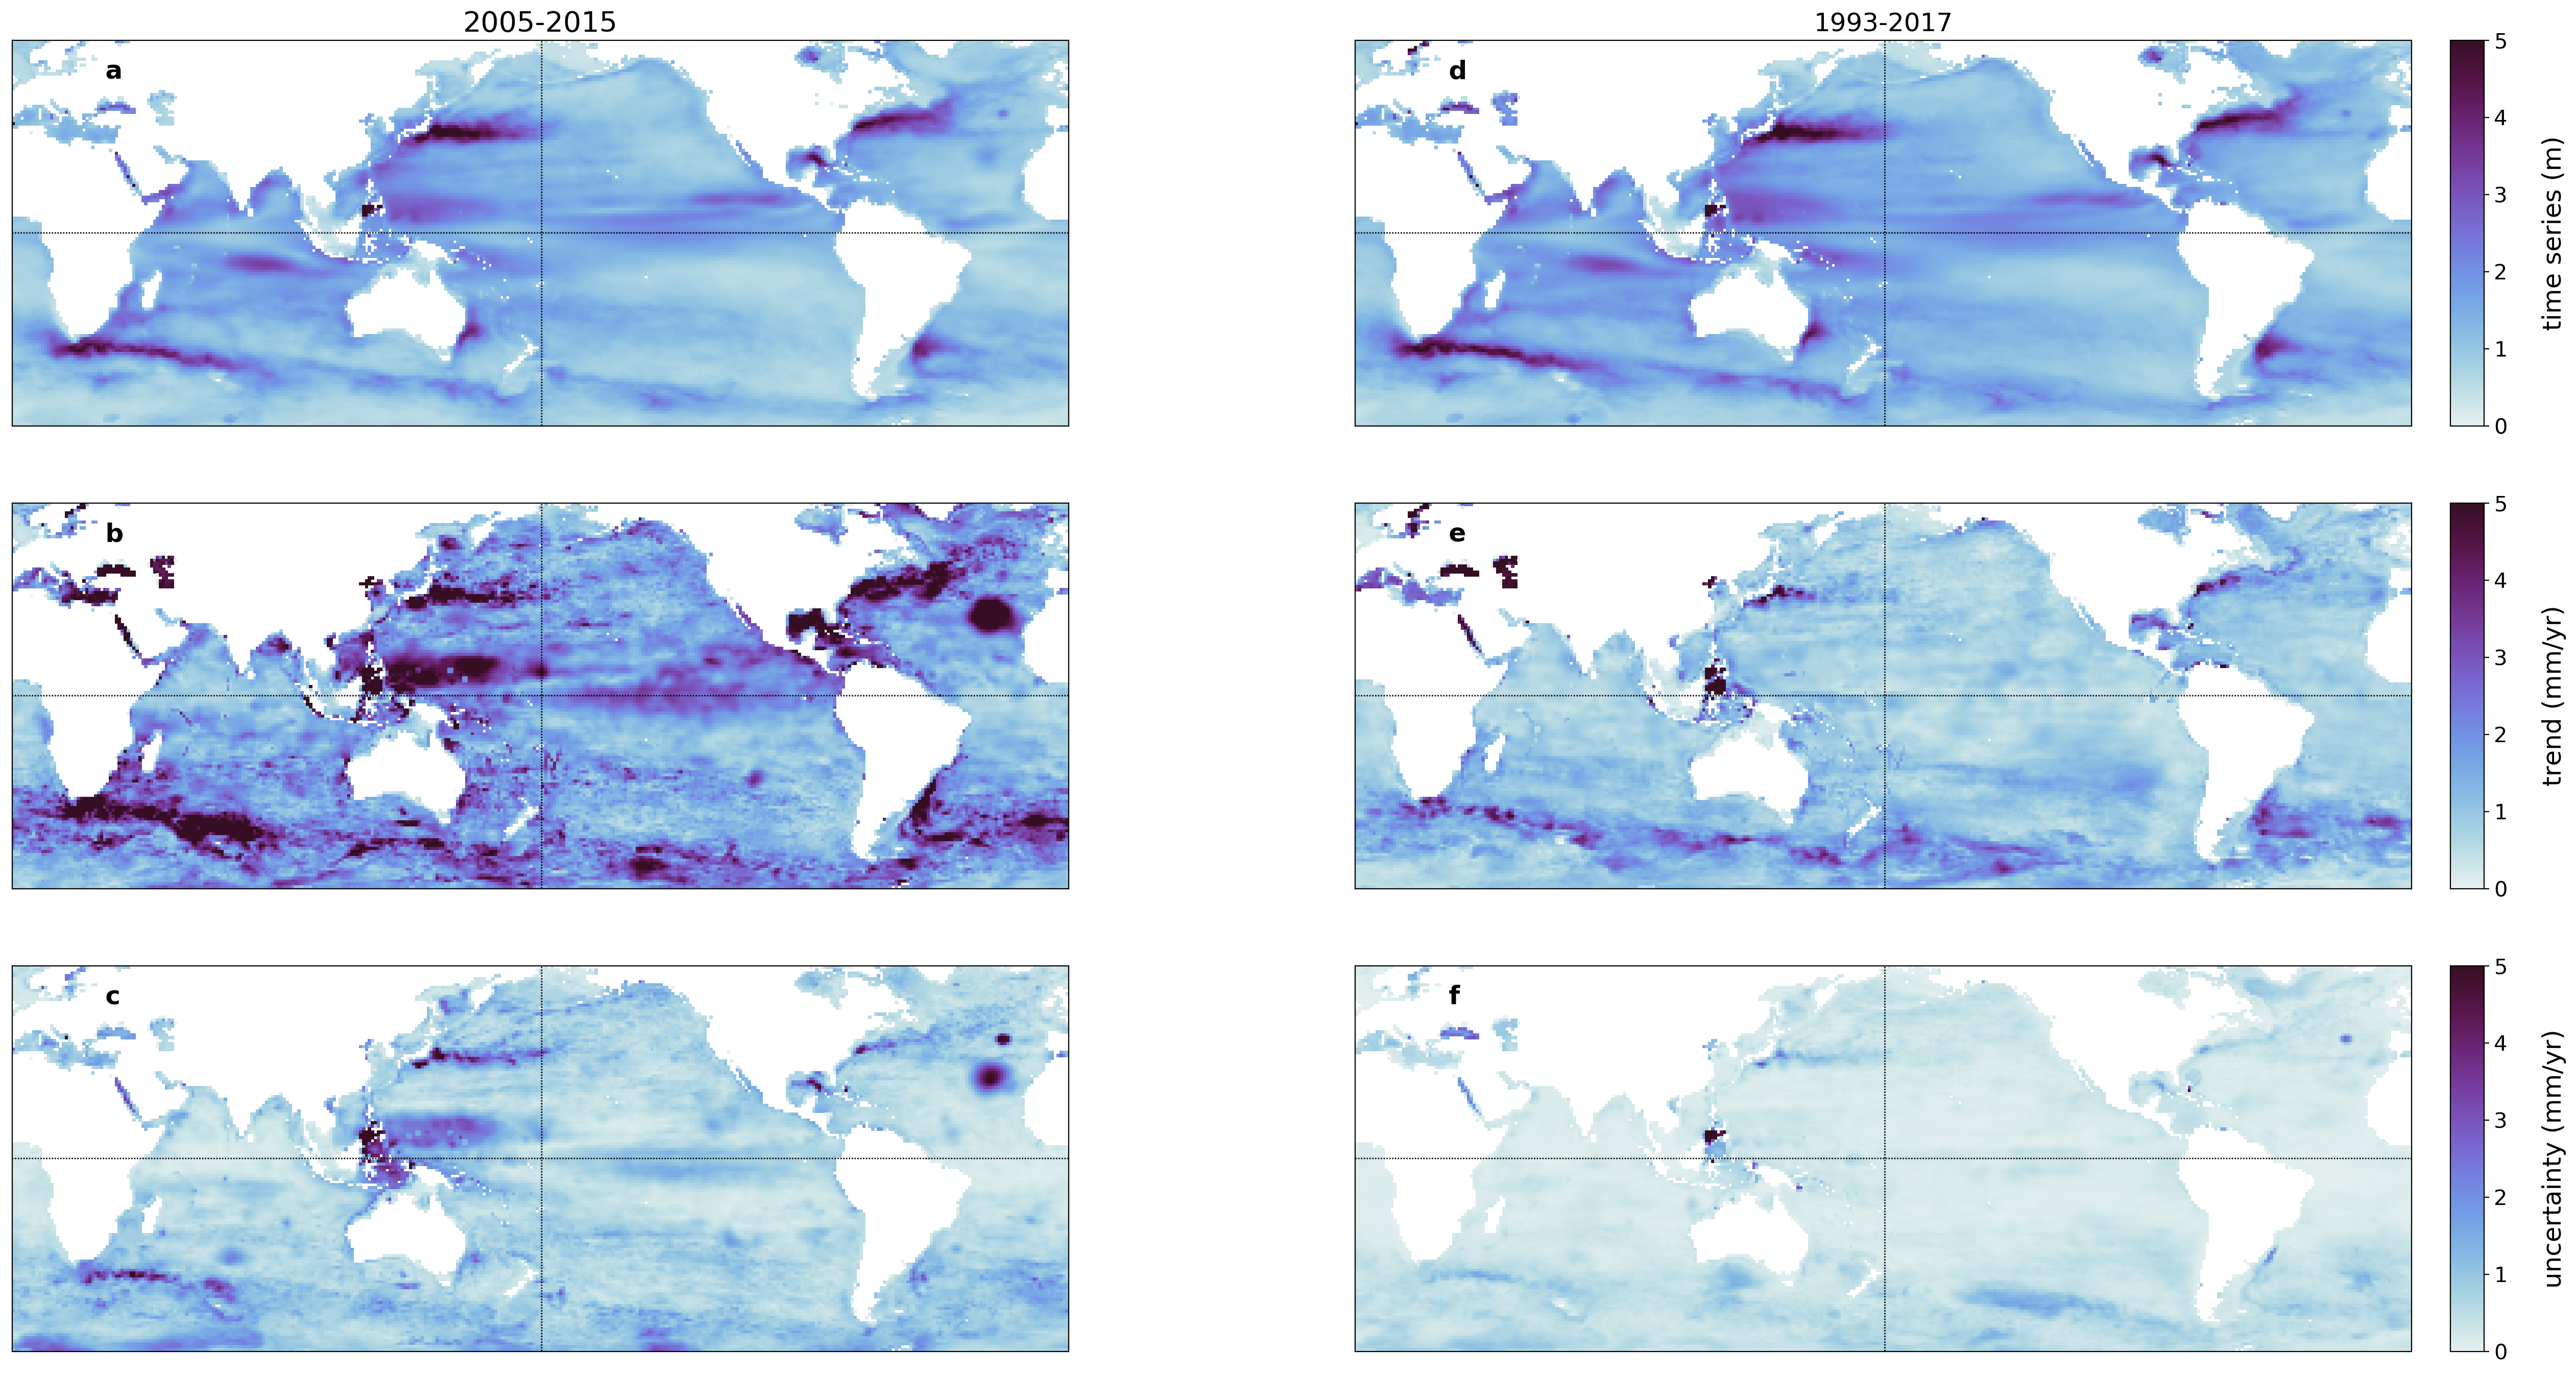

In [15]:
fig=plt.figure(figsize=(33,17),dpi=200)
gs = GridSpec(3, 6, figure=fig)

cmax=0.2
cmin=0
cmap=cm.cm.dense

###### 2005-2015
### time series
ax1 = plt.subplot(gs.new_subplotspec((0, 0),colspan=3))
data=x[0,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

plt.title('2005-2015',fontsize=20)

ax1.text(0.08,0.90,' a ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### trend
cmax=5
ax1 = plt.subplot(gs.new_subplotspec((1, 0),colspan=3))
data=x[1,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax1.text(0.08,0.90,' b ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### unc

ax1 = plt.subplot(gs.new_subplotspec((2, 0),colspan=3))
data=x[2,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax1.text(0.08,0.90,' c ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

###### 1993-2017
### time series
cmax=0.2
ax1 = plt.subplot(gs.new_subplotspec((0, 3),colspan=3))
data=x[3,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

plt.title('1993-2017',fontsize=18)

ax1.text(0.08,0.90,' d ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### trend
cmax=5
ax2 = plt.subplot(gs.new_subplotspec((1, 3),colspan=3))
data=x[4,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax2.text(0.08,0.90,' e ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax2.transAxes)

### unc

ax3 = plt.subplot(gs.new_subplotspec((2, 3),colspan=3))
data=x[5,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax3.text(0.08,0.90,' f ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax3.transAxes)


#%
cax = fig.add_axes([ax1.get_position().x1-0.02, # x position
                    ax1.get_position().y0, # y position 
                    0.01, # width
                    ax1.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\ntime series (m)',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax2.get_position().x1-0.02, # x position
                    ax2.get_position().y0, # y position 
                    0.01, # width
                    ax2.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\ntrend (mm/yr)',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax3.get_position().x1-0.02, # x position
                    ax3.get_position().y0, # y position 
                    0.01, # width
                    ax3.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\nuncertainty (mm/yr)',fontsize=18)
cbar.ax.tick_params(labelsize=15)


plt.show()


Figure. Standard deviation of the time series (a,d) in function of all the datasets and time; of the trend (b,e) and uncertainty (c,f) in function of all the datasets for AR(1)

In [16]:
i=0
j=15
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/time_series_regional_2005-2015.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)

label=['ts_2005','trend_2005','unc_2005','ts_1993','trend_1993','unc_1993']
x=np.zeros((len(label),len(lat),len(lon)))

data=np.array(ds.datamu[0:j,:,:,:])

std=np.nanstd(data,axis=(0,1))
x[i,:,:]=std

#%%

#%%

ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_2005-2015.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.trend[0:j,:,:,:])

std=np.nanstd(data,axis=(0,1))
i=1
x[i,:,:]=std

#%


data=np.array(ds.unc[0:j,:,:,:])
std=np.nanstd(data,axis=(0,1))

i=2
x[i,:,:]=std

#%% 1993-2017
j=10
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/time_series_regional_1993-2017.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.datamu[0:j,:,:,:])

std=np.nanstd(data,axis=(0,1))
i=3
x[i,:,:]=std
#%%


#%%
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_1993-2017.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.trend[0:j,:,:,:])

std=np.nanstd(data,axis=(0,1))
i=4
x[i,:,:]=std
#%

data=np.array(ds.unc[0:j,:,:,:])
std=np.nanstd(data,axis=(0,1))

i=5
x[i,:,:]=std


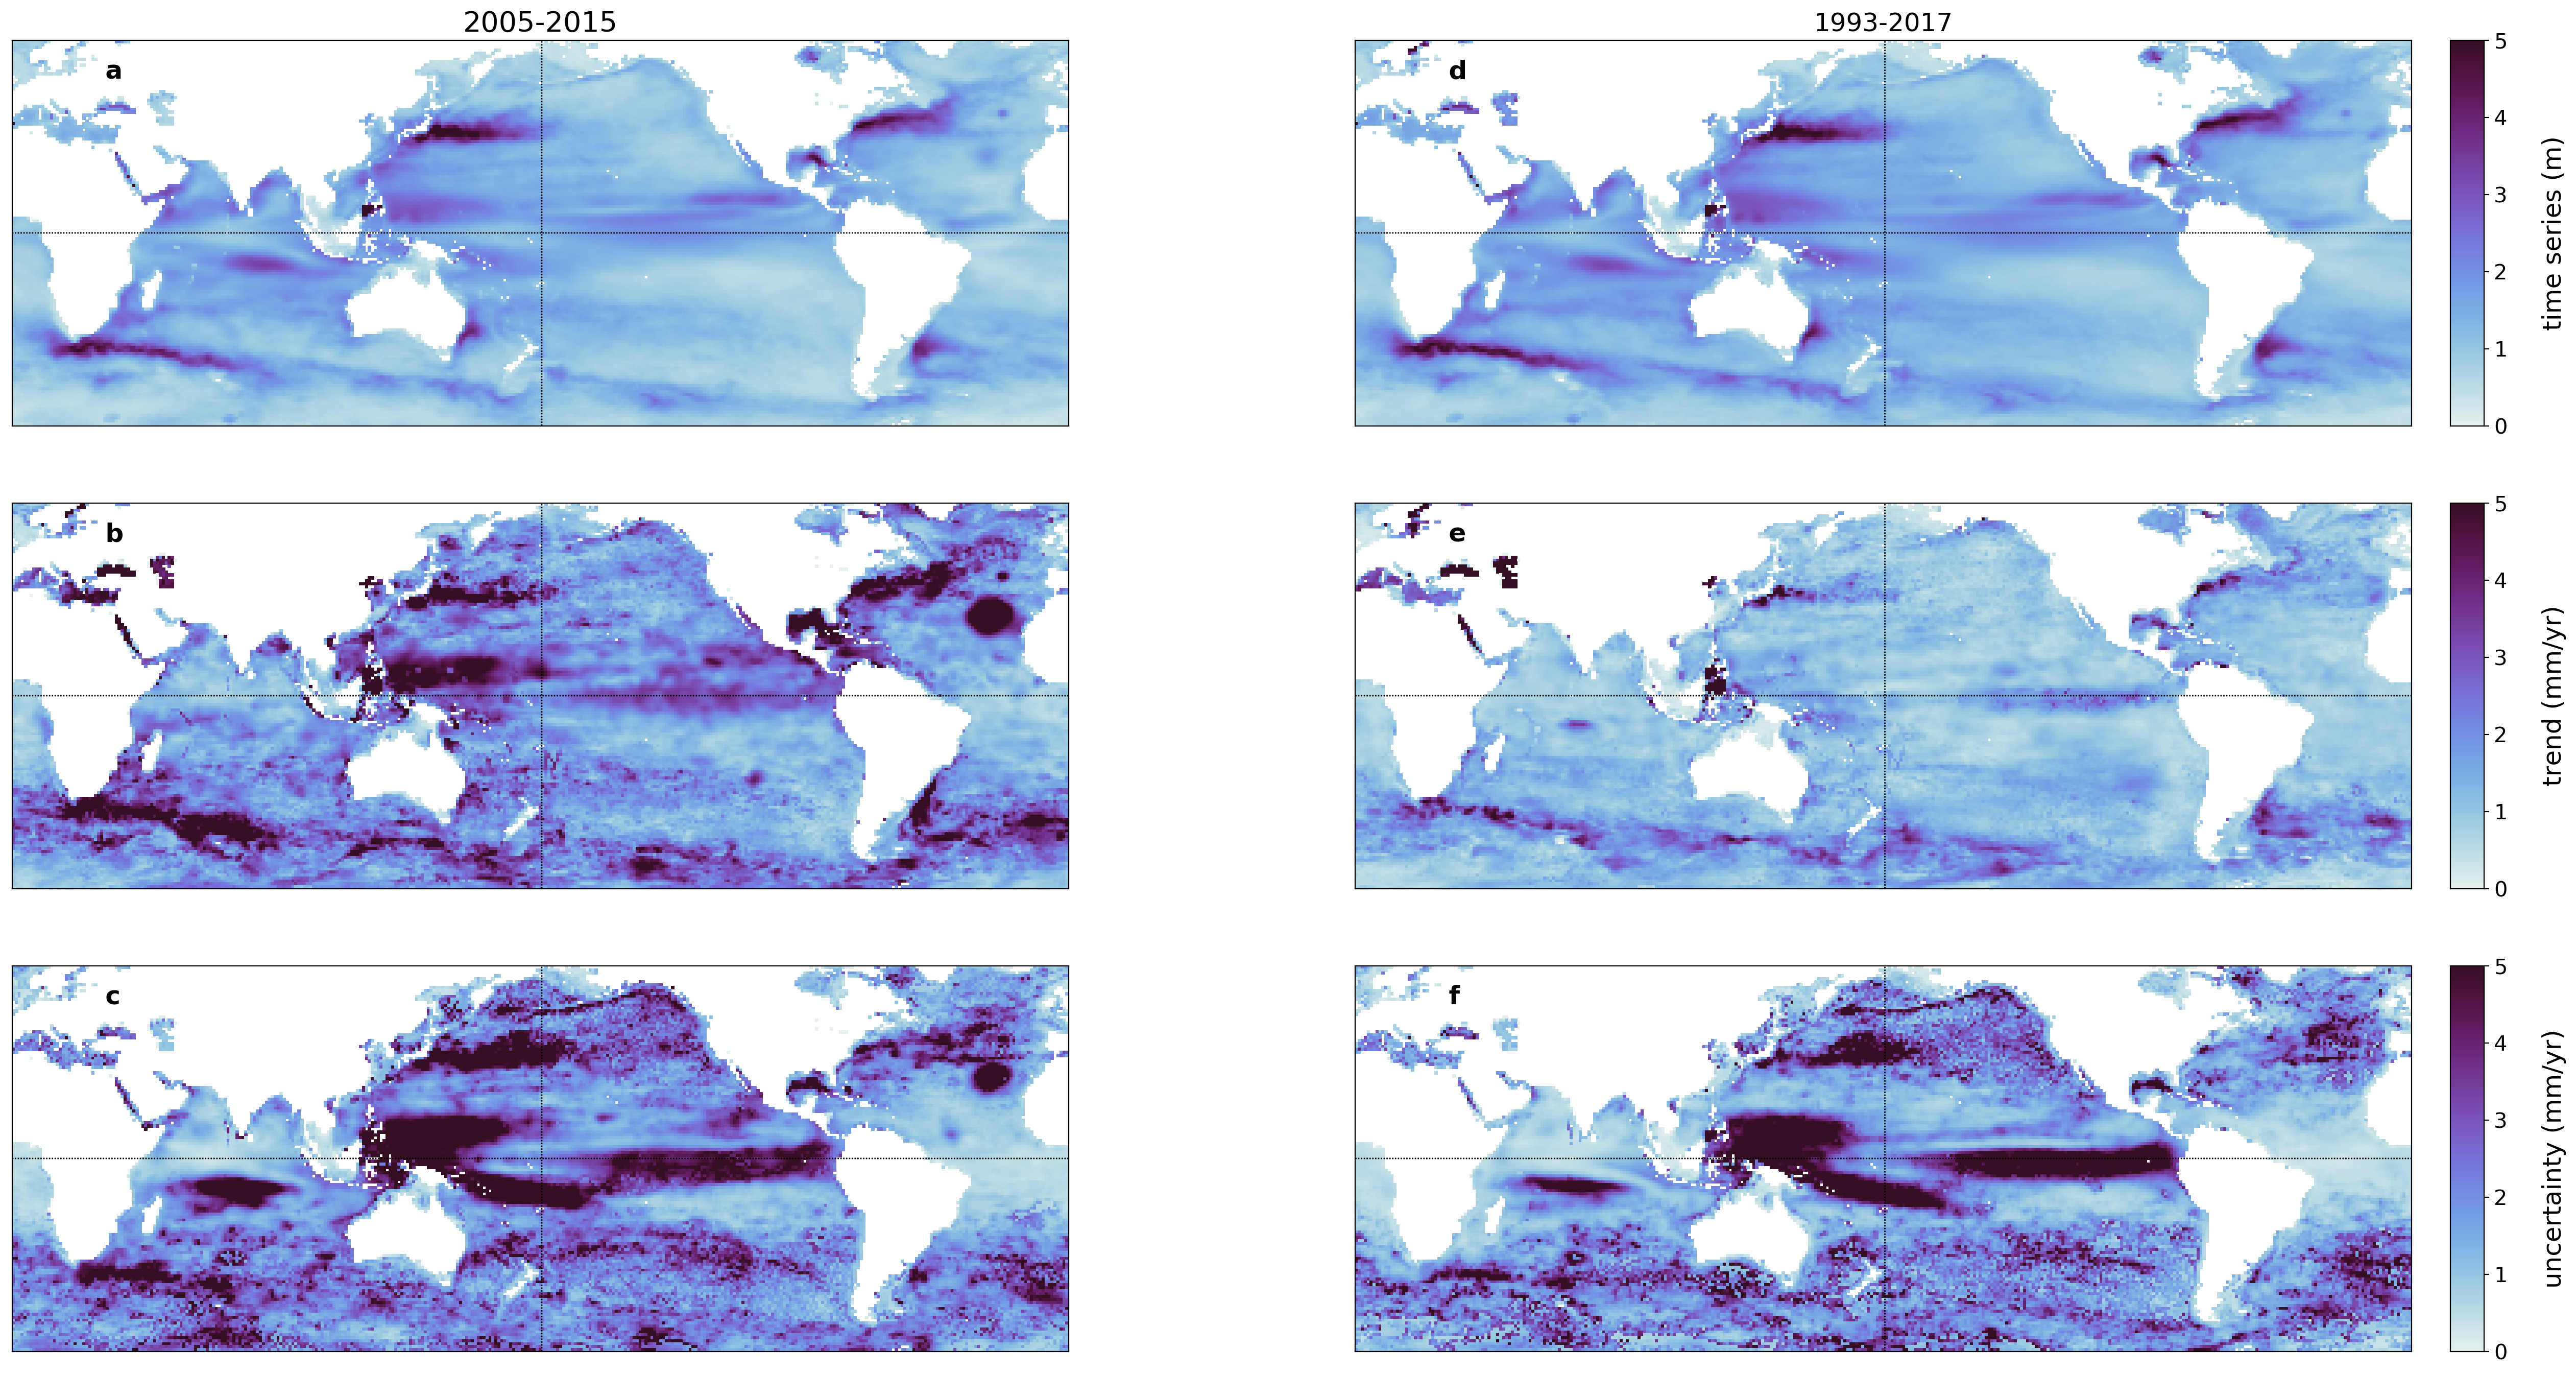

In [17]:
fig=plt.figure(figsize=(33,17),dpi=200)
gs = GridSpec(3, 6, figure=fig)

cmax=0.2
cmin=0
cmap=cm.cm.dense

###### 2005-2015
### time series
ax1 = plt.subplot(gs.new_subplotspec((0, 0),colspan=3))
data=x[0,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

plt.title('2005-2015',fontsize=20)

ax1.text(0.08,0.90,' a ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### trend
cmax=5
ax1 = plt.subplot(gs.new_subplotspec((1, 0),colspan=3))
data=x[1,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax1.text(0.08,0.90,' b ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### unc

ax1 = plt.subplot(gs.new_subplotspec((2, 0),colspan=3))
data=x[2,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax1.text(0.08,0.90,' c ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

###### 1993-2017
### time series
cmax=0.2
ax1 = plt.subplot(gs.new_subplotspec((0, 3),colspan=3))
data=x[3,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

plt.title('1993-2017',fontsize=18)

ax1.text(0.08,0.90,' d ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### trend
cmax=5
ax2 = plt.subplot(gs.new_subplotspec((1, 3),colspan=3))
data=x[4,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax2.text(0.08,0.90,' e ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax2.transAxes)

### unc

ax3 = plt.subplot(gs.new_subplotspec((2, 3),colspan=3))
data=x[5,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax3.text(0.08,0.90,' f ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax3.transAxes)


#%
cax = fig.add_axes([ax1.get_position().x1-0.02, # x position
                    ax1.get_position().y0, # y position 
                    0.01, # width
                    ax1.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\ntime series (m)',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax2.get_position().x1-0.02, # x position
                    ax2.get_position().y0, # y position 
                    0.01, # width
                    ax2.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\ntrend (mm/yr)',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax3.get_position().x1-0.02, # x position
                    ax3.get_position().y0, # y position 
                    0.01, # width
                    ax3.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\nuncertainty (mm/yr)',fontsize=18)
cbar.ax.tick_params(labelsize=15)


plt.show()


Figure.Standard deviation of the time series (a,d) in function of all the datasets and time; of the trend (b,e) and uncertainty (c,f) in function of all the datasets and all noise-models


In [21]:
i=0
j=18
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/time_series_regional_2005-2015.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)

label=['ts_2005','trend_2005','unc_2005','ts_1993','trend_1993','unc_1993']
x=np.zeros((len(label),len(lat),len(lon)))

data=np.array(ds.datamu[j,:,:,:])

std=np.nanstd(data,axis=(0))
x[i,:,:]=std

#%%

#%%

ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_2005-2015.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.trend[j,:,:,:])

std=np.nanstd(data,axis=(0))
i=1
x[i,:,:]=std

#%


data=np.array(ds.unc[j,:,:,:])
std=np.nanstd(data,axis=(0))

i=2
x[i,:,:]=std

#%% 1993-2017
j=12
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/time_series_regional_1993-2017.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.datamu[j,:,:,:])

std=np.nanstd(data,axis=(0))
i=3
x[i,:,:]=std
#%%


#%%
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_1993-2017.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.trend[j,:,:,:])

std=np.nanstd(data,axis=(0))
i=4
x[i,:,:]=std
#%

data=np.array(ds.unc[j,:,:,:])
std=np.nanstd(data,axis=(0))

i=5
x[i,:,:]=std


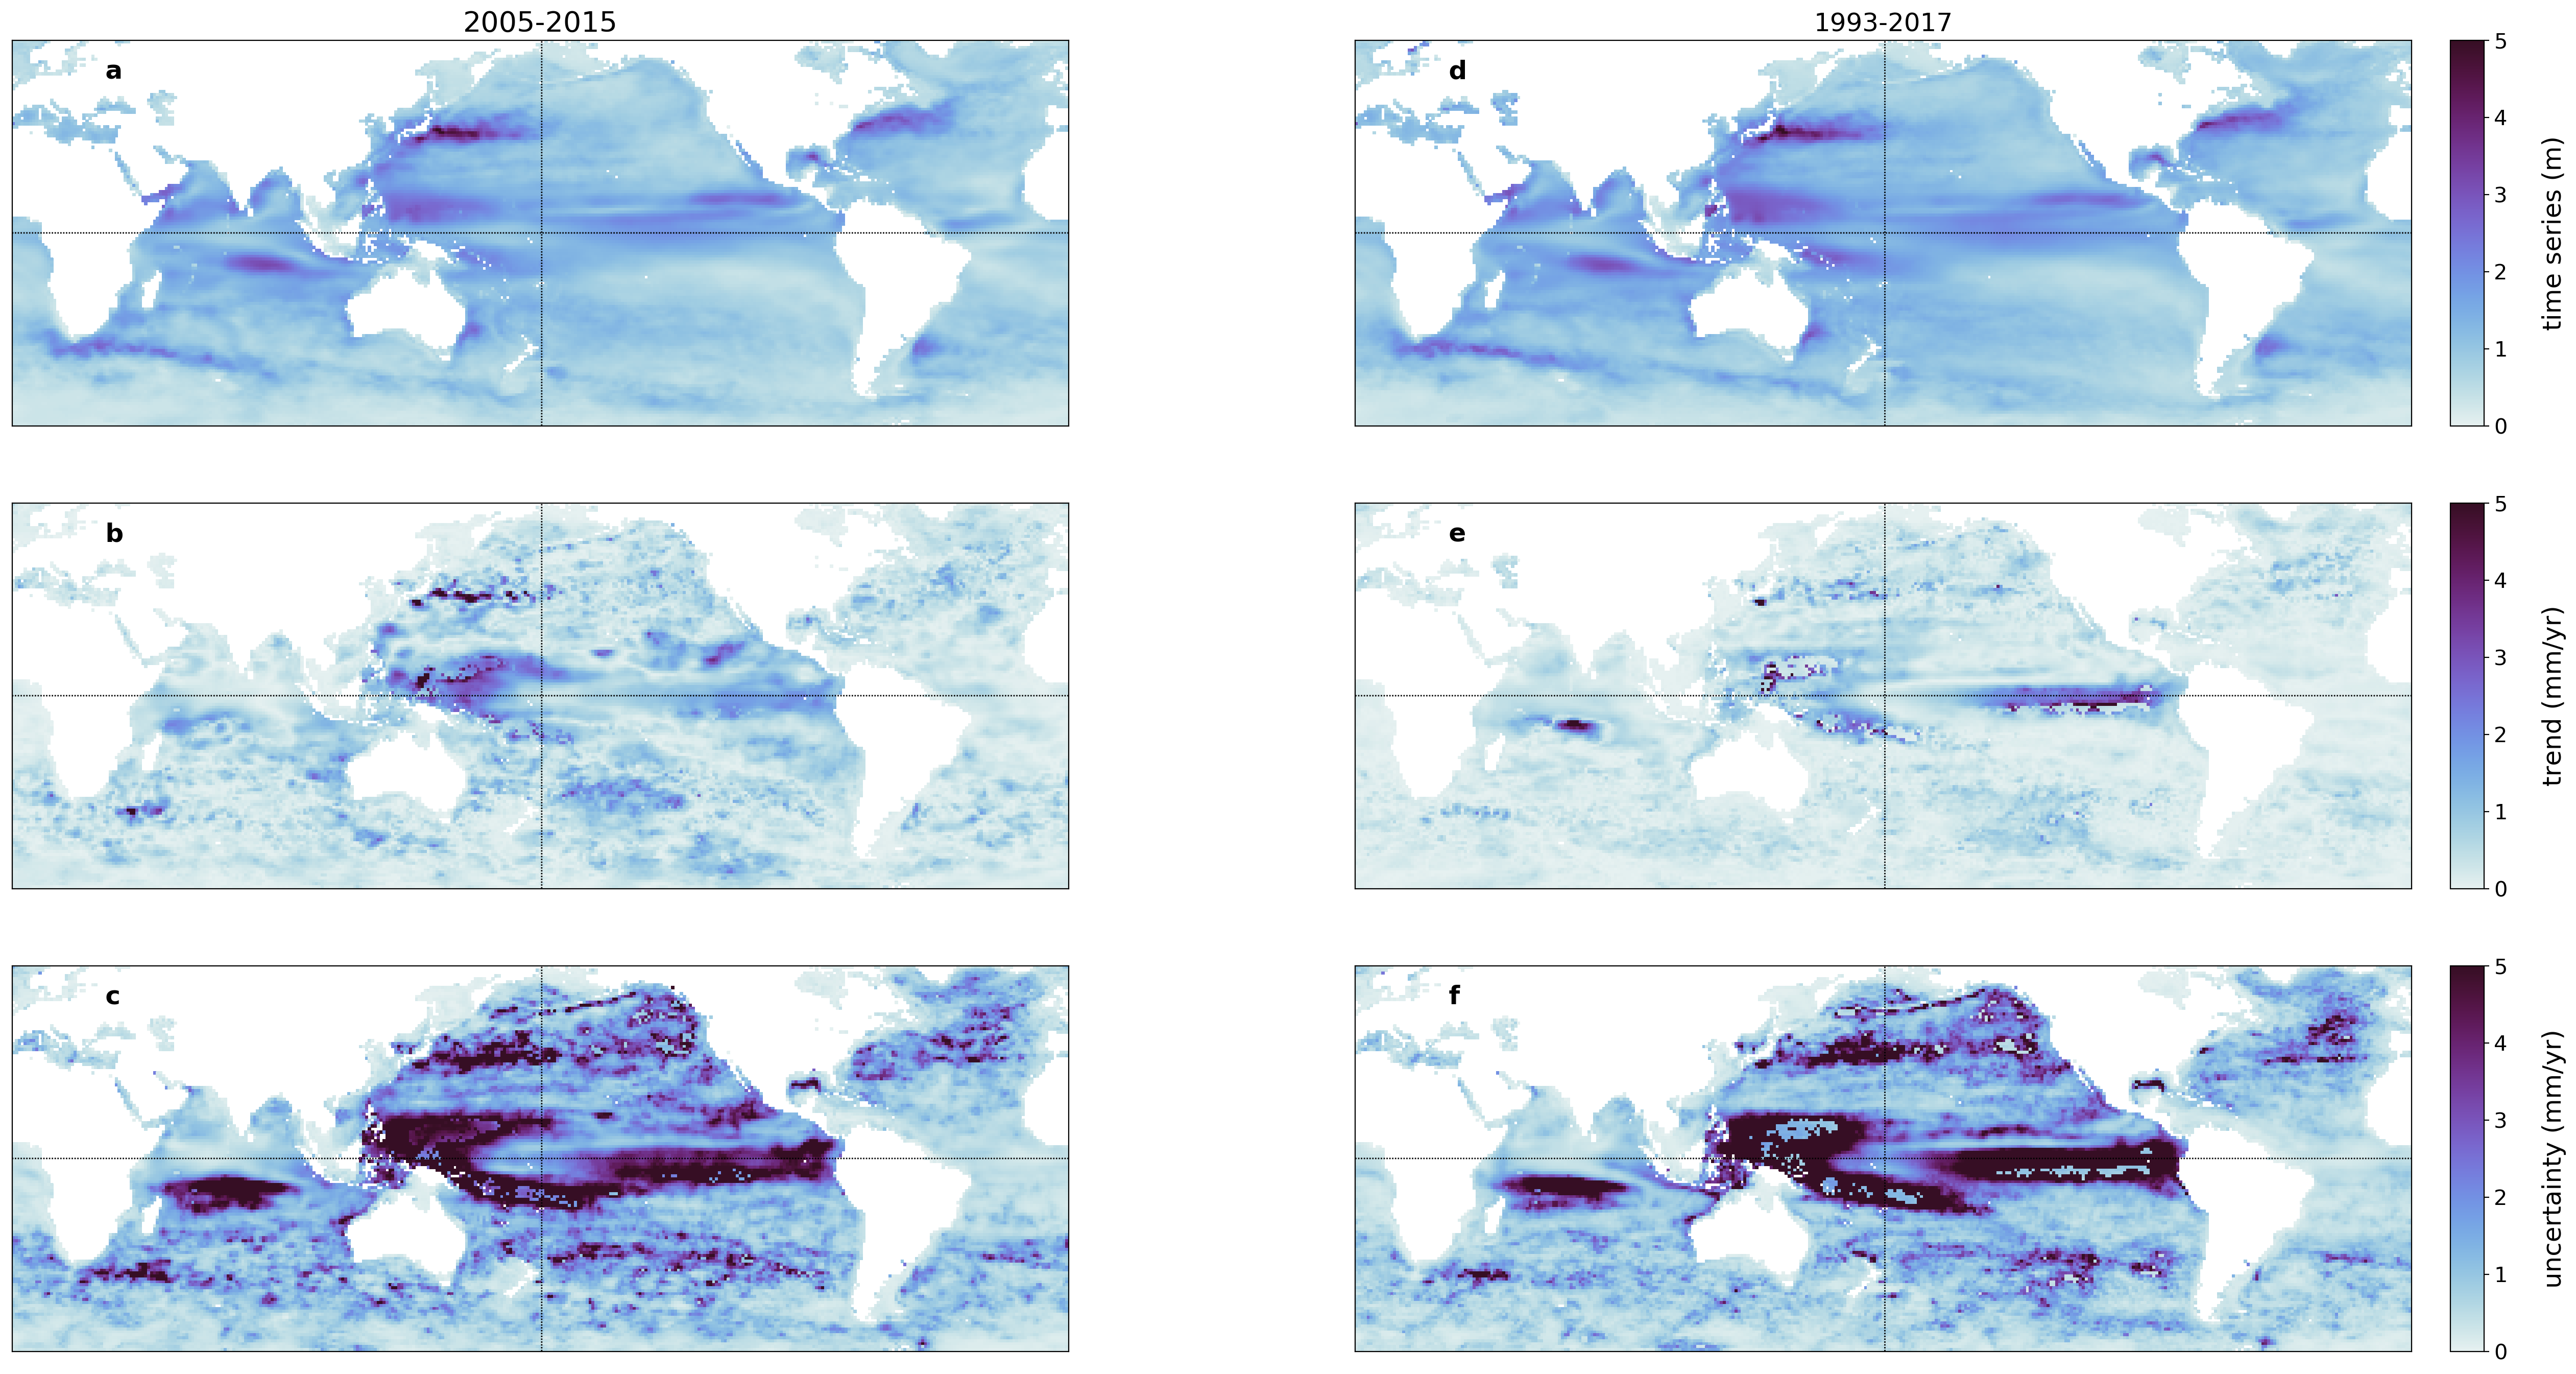

In [22]:
fig=plt.figure(figsize=(33,17),dpi=200)
gs = GridSpec(3, 6, figure=fig)

cmax=0.2
cmin=0
cmap=cm.cm.dense

###### 2005-2015
### time series
ax1 = plt.subplot(gs.new_subplotspec((0, 0),colspan=3))
data=x[0,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

plt.title('2005-2015',fontsize=20)

ax1.text(0.08,0.90,' a ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### trend
cmax=5
ax1 = plt.subplot(gs.new_subplotspec((1, 0),colspan=3))
data=x[1,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax1.text(0.08,0.90,' b ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### unc

ax1 = plt.subplot(gs.new_subplotspec((2, 0),colspan=3))
data=x[2,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax1.text(0.08,0.90,' c ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

###### 1993-2017
### time series
cmax=0.2
ax1 = plt.subplot(gs.new_subplotspec((0, 3),colspan=3))
data=x[3,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

plt.title('1993-2017',fontsize=18)

ax1.text(0.08,0.90,' d ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### trend
cmax=5
ax2 = plt.subplot(gs.new_subplotspec((1, 3),colspan=3))
data=x[4,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax2.text(0.08,0.90,' e ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax2.transAxes)

### unc

ax3 = plt.subplot(gs.new_subplotspec((2, 3),colspan=3))
data=x[5,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax3.text(0.08,0.90,' f ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax3.transAxes)


#%
cax = fig.add_axes([ax1.get_position().x1-0.02, # x position
                    ax1.get_position().y0, # y position 
                    0.01, # width
                    ax1.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\ntime series (m)',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax2.get_position().x1-0.02, # x position
                    ax2.get_position().y0, # y position 
                    0.01, # width
                    ax2.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\ntrend (mm/yr)',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax3.get_position().x1-0.02, # x position
                    ax3.get_position().y0, # y position 
                    0.01, # width
                    ax3.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\nuncertainty (mm/yr)',fontsize=18)
cbar.ax.tick_params(labelsize=15)


plt.show()


Figure.Ensemble mean Standard deviation of the time series (a,d) in function of time; of the trend (b,e) and uncertainty (c,f) in function of all noise-models


In [23]:
i=-1
j=18
n=3

#%%
## 2005-2015
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_2005-2015.nc')
ds
lat=np.array(ds.lat)
lon=np.array(ds.lon)

label=['trend_2005_AR1','unc_2005_AR1','trend_2005_ENS','unc_2005_ENS',
       'trend_1993_AR1','unc_1993_AR1','trend_2005_ENS','unc_2005_ENS']


x=np.zeros((len(label),len(lat),len(lon)))

#AR1 all datasets
data=np.array(ds.trend[:,n,:,:]) 
std=np.nanstd(data,axis=(0))
i=i+1
x[i,:,:]=std

#%
data=np.array(ds.unc[:,n,:,:])
std=np.nanstd(data,axis=(0))
i=i+1
x[i,:,:]=std

#ENS all noise models
data=np.array(ds.trend[j,:,:,:]) 
std=np.nanstd(data,axis=(0))
i=i+1
x[i,:,:]=std

#%
data=np.array(ds.unc[j,:,:,:])
std=np.nanstd(data,axis=(0))
i=i+1
x[i,:,:]=std

#%% 1993-2017
j=12

#%%
ds=xr.open_dataset('~/Desktop/paper1/steric/data/pub/trends_regional_1993-2017.nc')
ds

#AR1 all datasets
data=np.array(ds.trend[:,n,:,:]) 
std=np.nanstd(data,axis=(0))
i=i+1
x[i,:,:]=std

#%
data=np.array(ds.unc[:,n,:,:])
std=np.nanstd(data,axis=(0))
i=i+1
x[i,:,:]=std

#ENS all noise models
data=np.array(ds.trend[j,:,:,:]) 
std=np.nanstd(data,axis=(0))
i=i+1
x[i,:,:]=std

#%
data=np.array(ds.unc[j,:,:,:])
std=np.nanstd(data,axis=(0))
i=i+1
x[i,:,:]=std


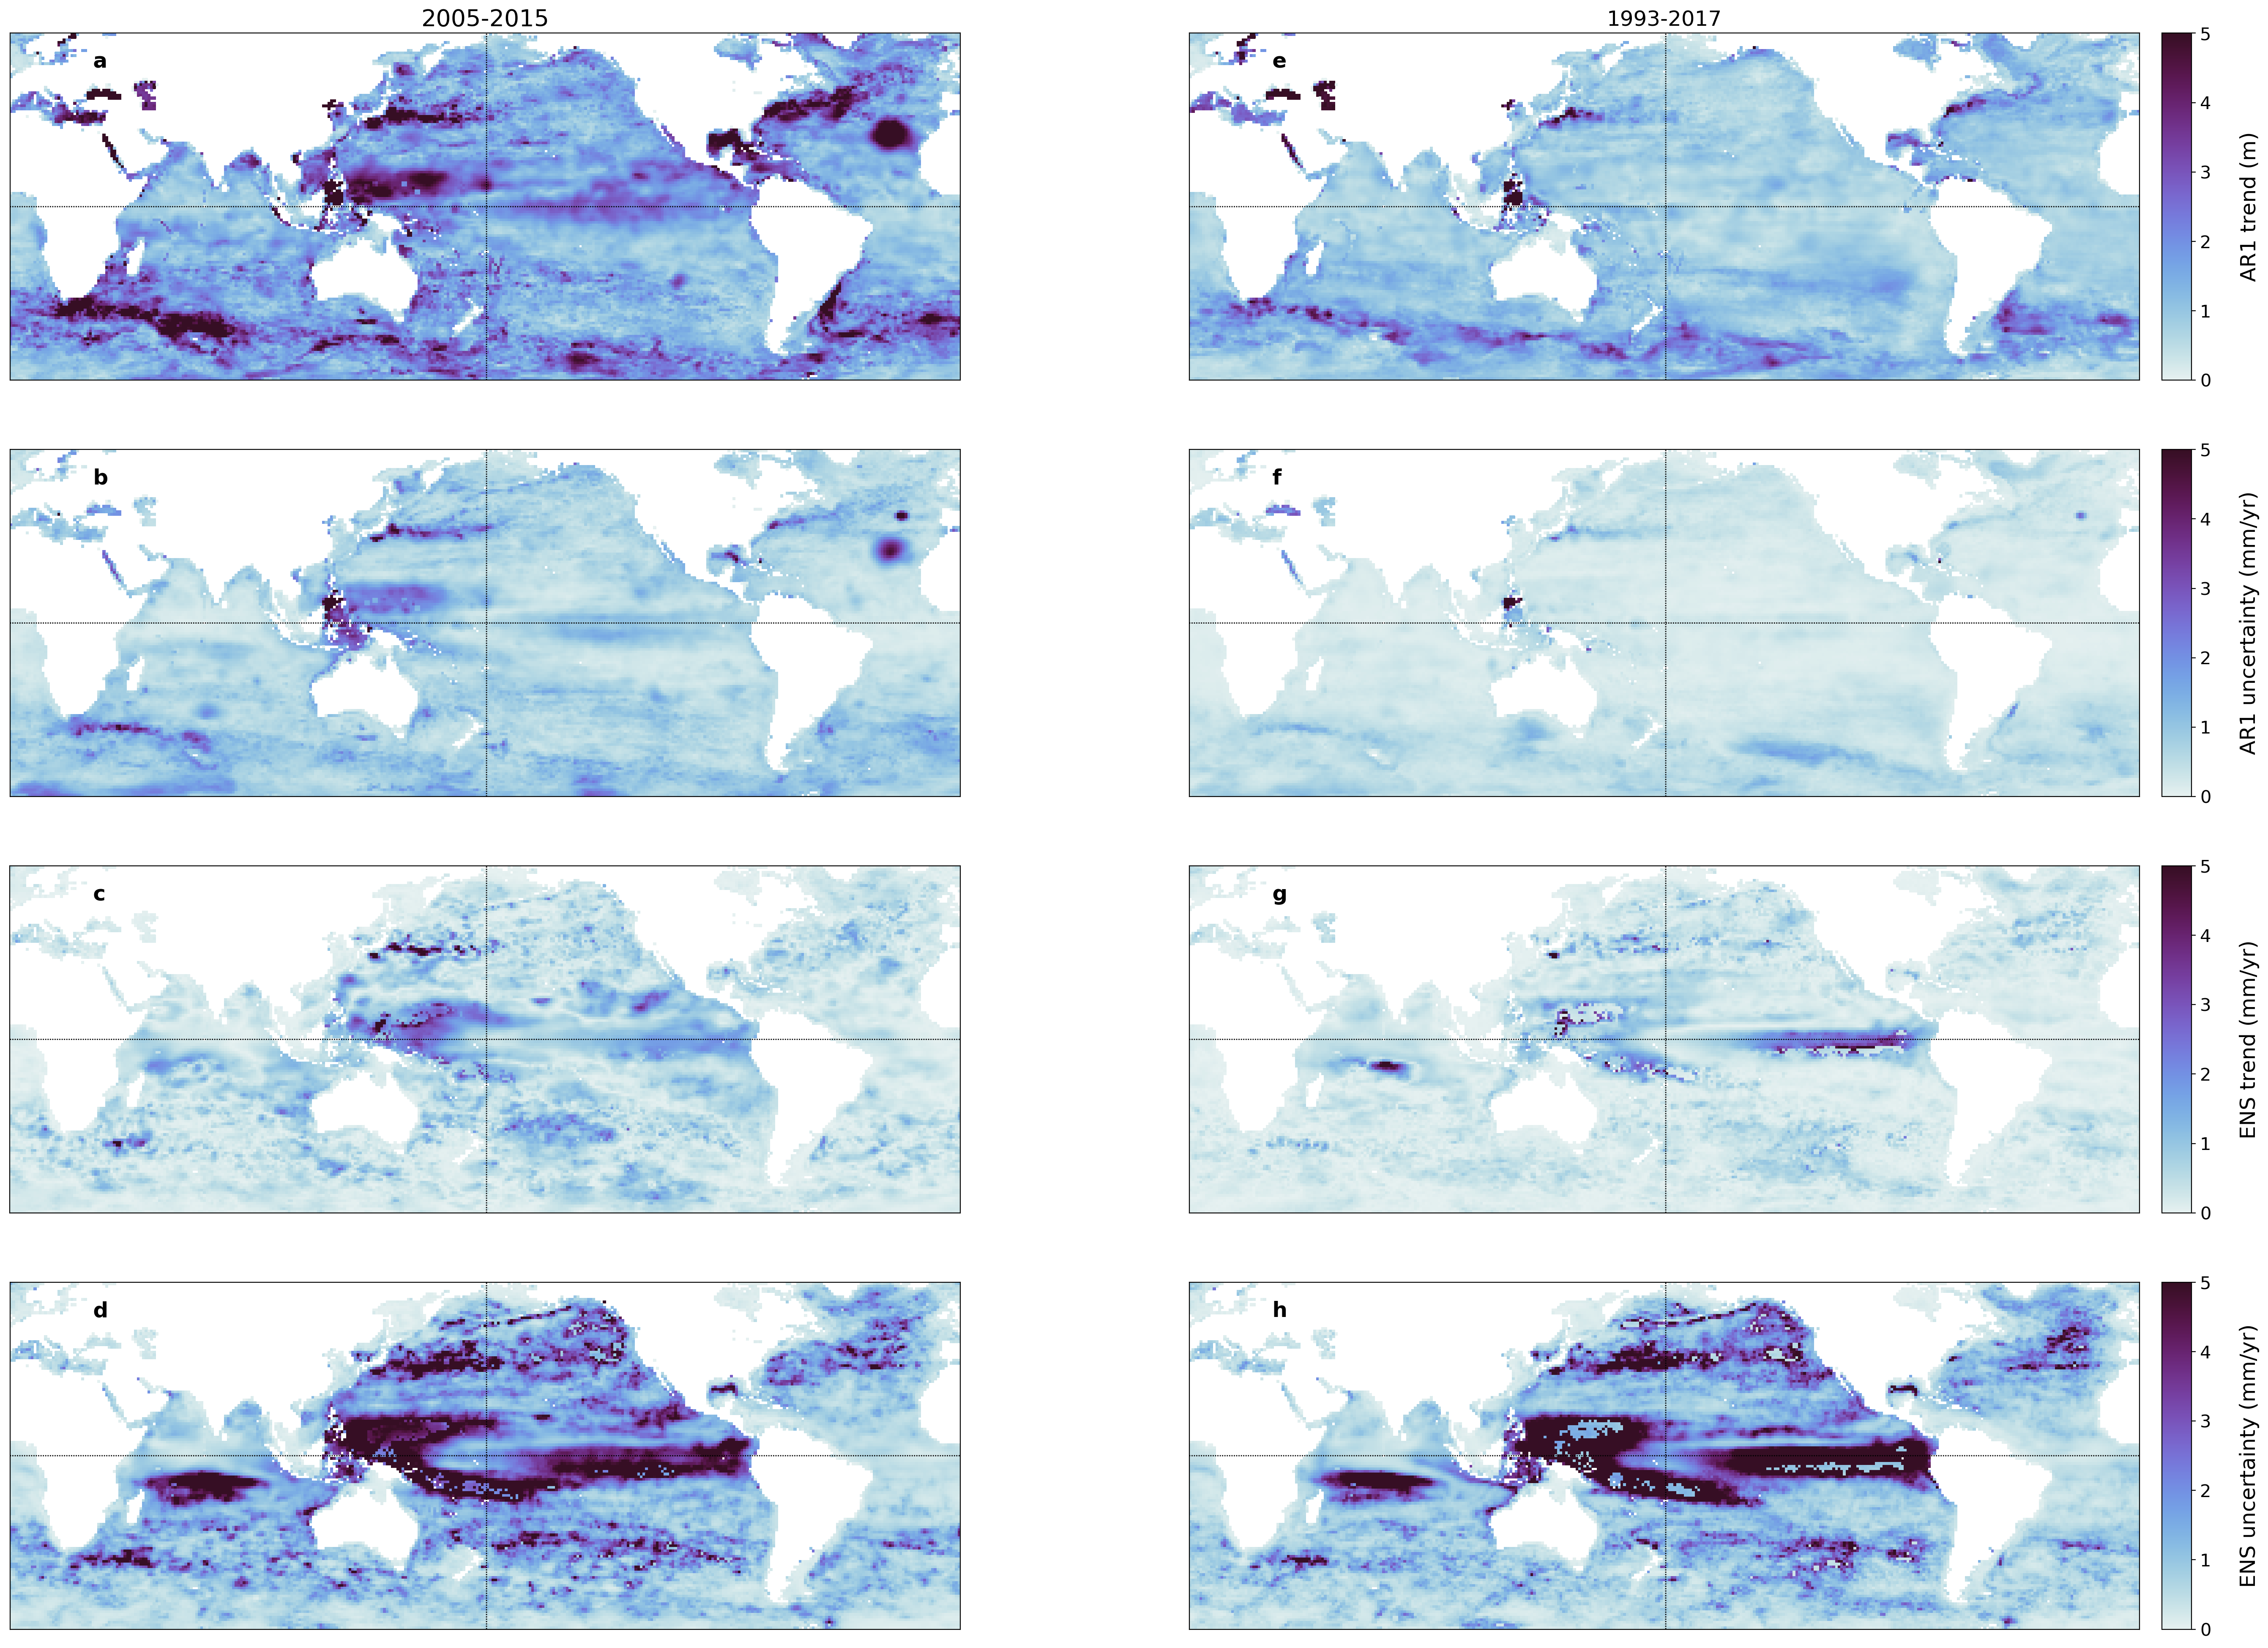

In [29]:
fig=plt.figure(figsize=(35,25),dpi=200)
gs = GridSpec(4, 6, figure=fig)

cmax=5
cmin=0
cmap=cm.cm.dense

###### 2005-2015
### Ar1 all datasets
ax1 = plt.subplot(gs.new_subplotspec((0, 0),colspan=3))
data=x[0,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

plt.title('2005-2015',fontsize=20)

ax1.text(0.08,0.90,' a ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### unc
ax1 = plt.subplot(gs.new_subplotspec((1, 0),colspan=3))
data=x[1,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax1.text(0.08,0.90,' b ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### ENS all datasets

ax1 = plt.subplot(gs.new_subplotspec((2, 0),colspan=3))
data=x[2,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax1.text(0.08,0.90,' c ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### unc

ax1 = plt.subplot(gs.new_subplotspec((3, 0),colspan=3))
data=x[3,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax1.text(0.08,0.90,' d ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

###### 1993-2017
### AR1 all datasets
ax1 = plt.subplot(gs.new_subplotspec((0, 3),colspan=3))
data=x[4,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])

plt.title('1993-2017',fontsize=18)

ax1.text(0.08,0.90,' e ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax1.transAxes)

### unc
ax2 = plt.subplot(gs.new_subplotspec((1, 3),colspan=3))
data=x[5,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax2.text(0.08,0.90,' f ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax2.transAxes)

### ENS all noise models

ax3 = plt.subplot(gs.new_subplotspec((2, 3),colspan=3))
data=x[6,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax3.text(0.08,0.90,' g ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax3.transAxes)

# unc
ax4 = plt.subplot(gs.new_subplotspec((3, 3),colspan=3))
data=x[7,:,:]

m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
           llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
            resolution='c')       
cax=m.pcolormesh(lon,lat,data,shading='flat',cmap=cmap)
plt.clim(cmin,cmax)
m.drawparallels([0])
m.drawmeridians([180])


ax4.text(0.08,0.90,' h ',weight='bold',fontsize=18,
        horizontalalignment='left',
        transform=ax4.transAxes)


#%
cax = fig.add_axes([ax1.get_position().x1-0.02, # x position
                    ax1.get_position().y0, # y position 
                    0.01, # width
                    ax1.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\nAR1 trend (m)',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax2.get_position().x1-0.02, # x position
                    ax2.get_position().y0, # y position 
                    0.01, # width
                    ax2.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\nAR1 uncertainty (mm/yr)',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax3.get_position().x1-0.02, # x position
                    ax3.get_position().y0, # y position 
                    0.01, # width
                    ax3.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\nENS trend (mm/yr)',fontsize=18)
cbar.ax.tick_params(labelsize=15)

cax = fig.add_axes([ax4.get_position().x1-0.02, # x position
                    ax4.get_position().y0, # y position 
                    0.01, # width
                    ax4.get_position().height]) # height
cbar=plt.colorbar( cax=cax, orientation='vertical') # Similar to fig.colorbar(im, cax = cax)
cbar.set_label(label='\nENS uncertainty (mm/yr)',fontsize=18)
cbar.ax.tick_params(labelsize=15)


plt.show()


fig.savefig('/Users/ccamargo/Desktop/paper1/figuresv4/pdf/SI_std.pdf',
            format='pdf',dpi=200,bbox_inches='tight')

fig.savefig('/Users/ccamargo/Desktop/paper1/figuresv4/png/SI_std.png',
            format='png',dpi=200,bbox_inches='tight')

Figure. Standard deviation of the (a,e,c,g) trend and (b,f,d,h) uncertainty from (a-d) 2005-2015 and (e-g) 1993-2017, for the (a,b,e,f) AR(1) noise model and all datasets, and for the (c,d,g,h) ensemble mean (ENS) and all noise models.